In [112]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from scipy import stats
import folium
from folium.plugins import HeatMap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


# **Loading Datasets**

The Bicing dataset includes bike-sharing usage data from August 2024 through January 2025 (inclusive). Due to computational constraints, we limited our analysis to the 50 most popular Bicing stations based on checkout frequency and percent occupancy. Integrating weather data could provide valuable additional insights during exploratory data analysis (EDA) and potentially enhance model performance. 

In [114]:
bicing_df = pd.read_csv('data/50_bicing_stations_2024_08_to_2025_01.csv')

weather_df = pd.read_csv('data/barcelona_weather_2024_08_to_2025_01.csv')

In [115]:
bicing_df.sample(10)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,V1
1718706,510.0,2.0,0.0,2.0,20.0,1.733024e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.733024e+09,0.0,NaN
2389356,84.0,19.0,16.0,3.0,8.0,1.737080e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.737080e+09,0.0,NaN
2473681,119.0,12.0,11.0,1.0,25.0,1.737588e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.737589e+09,0.0,NaN
256939,230.0,16.0,15.0,1.0,9.0,1.724117e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.724117e+09,0.0,NaN
1910866,224.0,1.0,0.0,1.0,21.0,1.734182e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.734182e+09,0.0,NaN
2145348,438.0,4.0,0.0,4.0,22.0,1.735602e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.735602e+09,0.0,NaN
729840,414.0,23.0,19.0,4.0,8.0,1.726976e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.726976e+09,0.0,NaN
975378,223.0,0.0,0.0,0.0,33.0,1.728544e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.728544e+09,0.0,NaN
1017633,359.0,21.0,20.0,1.0,5.0,1.728798e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.728798e+09,0.0,NaN
2178523,118.0,8.0,7.0,1.0,19.0,1.735800e+09,True,IN_SERVICE,1.0,1.0,1.0,NaN,1.735800e+09,0.0,NaN


In [116]:
weather_df.sample(10)

,timestamp,temperature,precipitation,wind_speed,weather_category
4413,2025-01-31 21:00:00,6.0,0.0,9.0,clear
2973,2024-12-02 21:00:00,9.0,0.0,1.8,clear
4035,2025-01-16 03:00:00,-1.0,0.0,7.6,clear
2373,2024-11-07 21:00:00,13.0,0.0,7.6,clear
2302,2024-11-04 22:00:00,17.0,0.0,1.8,cloudy
2950,2024-12-01 22:00:00,11.0,0.0,3.6,clear
741,2024-08-31 21:00:00,25.0,NaN,3.6,clear
3501,2024-12-24 21:00:00,6.0,0.0,11.2,clear
35,2024-08-02 11:00:00,34.0,0.0,14.8,clear
3075,2024-12-07 03:00:00,10.0,0.0,1.8,cloudy


In [117]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4416 entries, 0 to 4415
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         4416 non-null   object 
 1   temperature       4416 non-null   float64
 2   precipitation     4165 non-null   float64
 3   wind_speed        4416 non-null   float64
 4   weather_category  4416 non-null   object 
dtypes: float64(3), object(2)
memory usage: 172.6+ KB


**Preparing two datasets for the merge (we need to add weather data to our Bicing data)**

In [118]:
# Convert 'last_reported' from Unix timestamp to datetime
bicing_df['last_reported'] = pd.to_datetime(bicing_df['last_reported'], unit='s')

# Create a new column rounded to the nearest hour
bicing_df['timestamp_hour'] = bicing_df['last_reported'].dt.floor('H')

# Convert weather timestamp to datetime as well
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])


# **Dataset creation & Feature Engineering**

In [119]:
# Remove irrelevant columns
bicing_df.drop(columns=['traffic', 'V1'], inplace=True)


**Computing target variable: Checkouts (Checkouts_hour_station)**


In [120]:

bicing_df = bicing_df.sort_values(["station_id", "timestamp_hour"])
bicing_df["diff_bikes"] = bicing_df.groupby("station_id")["num_bikes_available"].diff()

In [121]:
bicing_df.head()

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,last_updated,ttl,timestamp_hour,diff_bikes
0,24.0,18.0,13.0,5.0,17.0,2024-07-31 21:56:13,True,IN_SERVICE,1.0,1.0,1.0,1.722463e+09,0.0,2024-07-31 21:00:00,NaN
50,24.0,19.0,13.0,6.0,16.0,2024-07-31 22:04:53,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,1.0
100,24.0,18.0,13.0,5.0,17.0,2024-07-31 22:09:11,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,-1.0
150,24.0,18.0,13.0,5.0,17.0,2024-07-31 22:13:31,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,0.0
200,24.0,17.0,13.0,4.0,18.0,2024-07-31 22:17:50,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,-1.0


In [122]:
bicing_df["checkouts"] = bicing_df["diff_bikes"].apply(lambda x: -x if x < 0 else 0)

In [123]:
bicing_df["checkouts_hour_station"] = (
    bicing_df.groupby(["timestamp_hour", "station_id"])["checkouts"]
    .transform("sum")
)

In [124]:
bicing_df.query("station_id == 24.0").head(10)

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,last_updated,ttl,timestamp_hour,diff_bikes,checkouts,checkouts_hour_station
0,24.0,18.0,13.0,5.0,17.0,2024-07-31 21:56:13,True,IN_SERVICE,1.0,1.0,1.0,1.722463e+09,0.0,2024-07-31 21:00:00,NaN,0.0,0.0
50,24.0,19.0,13.0,6.0,16.0,2024-07-31 22:04:53,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,1.0,0.0,5.0
100,24.0,18.0,13.0,5.0,17.0,2024-07-31 22:09:11,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,-1.0,1.0,5.0
150,24.0,18.0,13.0,5.0,17.0,2024-07-31 22:13:31,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,0.0,0.0,5.0
200,24.0,17.0,13.0,4.0,18.0,2024-07-31 22:17:50,True,IN_SERVICE,1.0,1.0,1.0,1.722464e+09,0.0,2024-07-31 22:00:00,-1.0,1.0,5.0
250,24.0,17.0,14.0,3.0,18.0,2024-07-31 22:22:10,True,IN_SERVICE,1.0,1.0,1.0,1.722465e+09,0.0,2024-07-31 22:00:00,0.0,0.0,5.0
300,24.0,17.0,14.0,3.0,18.0,2024-07-31 22:26:27,True,IN_SERVICE,1.0,1.0,1.0,1.722465e+09,0.0,2024-07-31 22:00:00,0.0,0.0,5.0
350,24.0,17.0,14.0,3.0,18.0,2024-07-31 22:30:48,True,IN_SERVICE,1.0,1.0,1.0,1.722465e+09,0.0,2024-07-31 22:00:00,0.0,0.0,5.0
400,24.0,15.0,14.0,1.0,20.0,2024-07-31 22:39:29,True,IN_SERVICE,1.0,1.0,1.0,1.722466e+09,0.0,2024-07-31 22:00:00,-2.0,2.0,5.0
450,24.0,14.0,14.0,0.0,21.0,2024-07-31 22:43:48,True,IN_SERVICE,1.0,1.0,1.0,1.722466e+09,0.0,2024-07-31 22:00:00,-1.0,1.0,5.0


In [125]:
bicing_df = bicing_df.rename(columns={
    "num_bikes_available_types.ebike": "ebike_available",
    "num_bikes_available_types.mechanical": "mechanical_available"
})

In [126]:
bicing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2601491 entries, 0 to 2601490
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   station_id              float64       
 1   num_bikes_available     float64       
 2   mechanical_available    float64       
 3   ebike_available         float64       
 4   num_docks_available     float64       
 5   last_reported           datetime64[ns]
 6   is_charging_station     bool          
 7   status                  object        
 8   is_installed            float64       
 9   is_renting              float64       
 10  is_returning            float64       
 11  last_updated            float64       
 12  ttl                     float64       
 13  timestamp_hour          datetime64[ns]
 14  diff_bikes              float64       
 15  checkouts               float64       
 16  checkouts_hour_station  float64       
dtypes: bool(1), datetime64[ns](2), float64(13), object(

**Creating an hourly summary Dataframe**

In [127]:
hourly_df = (
    bicing_df
    .drop(columns=["last_reported", "last_updated", "checkouts", "diff_bikes"], errors="ignore")
    .groupby(["timestamp_hour", "station_id"], as_index=False)
    .agg(
        num_bikes_available_mean=("num_bikes_available", "mean"),
        mechanical_available=("mechanical_available", "mean"),
        ebike_available=("ebike_available", "mean"),
        num_docks_available_mean=("num_docks_available", "mean"),
        num_docks_available_max=("num_docks_available", "max"),
        is_charging_station=("is_charging_station", "first"),
        status=("status", "first"),
        is_installed=("is_installed", "first"),
        is_renting=("is_renting", "first"),
        is_returning=("is_returning", "first"),
        ttl=("ttl", "first"),
        timestamp_hour=("timestamp_hour", "first"),
        checkouts_hour_station=("checkouts_hour_station", "first")
    )
)

hourly_df.head()

,station_id,num_bikes_available_mean,mechanical_available,ebike_available,num_docks_available_mean,num_docks_available_max,is_charging_station,status,is_installed,is_renting,is_returning,ttl,timestamp_hour,checkouts_hour_station
0,24.0,18.0,13.0,5.0,17.0,17.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0
1,26.0,7.0,5.0,2.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0
2,29.0,3.0,0.0,3.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0
3,41.0,20.0,19.0,1.0,3.0,3.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0
4,42.0,3.0,0.0,3.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0


In [128]:
hourly_df.query("station_id == 24.0").head(10)

,station_id,num_bikes_available_mean,mechanical_available,ebike_available,num_docks_available_mean,num_docks_available_max,is_charging_station,status,is_installed,is_renting,is_returning,ttl,timestamp_hour,checkouts_hour_station
0,24.0,18.000000,13.000000,5.000000,17.000000,17.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0
50,24.0,16.583333,13.750000,2.833333,18.416667,21.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 22:00:00,5.0
100,24.0,18.500000,15.000000,3.500000,16.666667,18.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 23:00:00,1.0
150,24.0,18.250000,16.000000,2.250000,17.750000,19.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-08-01 00:00:00,3.0
200,24.0,21.166667,17.000000,4.166667,15.416667,16.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-08-01 01:00:00,0.0
250,24.0,18.583333,16.000000,2.583333,18.000000,18.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-08-01 02:00:00,4.0
300,24.0,19.000000,16.000000,3.000000,17.166667,18.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-08-01 03:00:00,3.0
350,24.0,16.583333,15.166667,1.416667,19.750000,22.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-08-01 04:00:00,6.0
400,24.0,12.083333,11.166667,0.916667,24.833333,32.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-08-01 05:00:00,11.0
450,24.0,2.666667,2.500000,0.166667,35.083333,39.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-08-01 06:00:00,5.0


**Merging our Bicing hourly dataset with the weather data**

In [129]:
final_df = pd.merge(
    hourly_df,      
    weather_df,    
    left_on='timestamp_hour',
    right_on='timestamp',   
    how='left'
)


final_df.drop('timestamp', axis=1, inplace=True)

In [130]:
final_df.head()

,station_id,num_bikes_available_mean,mechanical_available,ebike_available,num_docks_available_mean,num_docks_available_max,is_charging_station,status,is_installed,is_renting,is_returning,ttl,timestamp_hour,checkouts_hour_station,temperature,precipitation,wind_speed,weather_category
0,24.0,18.0,13.0,5.0,17.0,17.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0,NaN,NaN,NaN,NaN
1,26.0,7.0,5.0,2.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0,NaN,NaN,NaN,NaN
2,29.0,3.0,0.0,3.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0,NaN,NaN,NaN,NaN
3,41.0,20.0,19.0,1.0,3.0,3.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0,NaN,NaN,NaN,NaN
4,42.0,3.0,0.0,3.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,1.0,0.0,2024-07-31 21:00:00,0.0,NaN,NaN,NaN,NaN


**Setting Timestamp hour as index; adding days, hours of day and month;creating lag features

In [131]:

final_df["timestamp_hour"] = pd.to_datetime(final_df["timestamp_hour"])
final_df.set_index("timestamp_hour", inplace=True)


final_df["day_of_week"] = final_df.index.dayofweek
final_df["hour_of_day"] = final_df.index.hour
final_df["month"] = final_df.index.month



In [132]:
# Create a 1-hour lag feature
final_df["checkouts_hour_station_lag1"] = (
    final_df.groupby("station_id")["checkouts_hour_station"]
    .shift(1)
)

# Create a 24-hour lag feature (same hour on the previous day)
final_df["checkouts_hour_station_lag24"] = (
    final_df.groupby("station_id")["checkouts_hour_station"]
    .shift(24)
)



In [133]:
final_df.sample(10)

,station_id,num_bikes_available_mean,mechanical_available,ebike_available,num_docks_available_mean,num_docks_available_max,is_charging_station,status,is_installed,is_renting,...,checkouts_hour_station,temperature,precipitation,wind_speed,weather_category,day_of_week,hour_of_day,month,checkouts_hour_station_lag1,checkouts_hour_station_lag24
timestamp_hour,,,,,,,,,,,,,,,,,,,,,
2024-10-11 16:00:00,148.0,11.833333,7.000000,4.833333,11.916667,14.0,True,IN_SERVICE,1.0,1.0,...,8.0,20.0,0.0,14.8,clear,4,16,10,4.0,9.0
2025-01-05 00:00:00,61.0,2.416667,1.000000,1.416667,14.583333,15.0,True,IN_SERVICE,1.0,1.0,...,2.0,5.0,0.0,0.0,cloudy,6,0,1,2.0,0.0
2025-01-14 05:00:00,319.0,3.250000,0.000000,3.250000,24.333333,27.0,True,IN_SERVICE,1.0,1.0,...,7.0,-3.0,0.0,5.4,clear,1,5,1,2.0,3.0
2024-09-26 21:00:00,76.0,3.916667,0.000000,3.916667,25.750000,30.0,True,IN_SERVICE,1.0,1.0,...,2.0,24.0,0.0,9.4,clear,3,21,9,3.0,8.0
2024-12-26 21:00:00,112.0,3.916667,1.083333,2.833333,15.583333,18.0,True,IN_SERVICE,1.0,1.0,...,4.0,9.0,0.0,3.6,cloudy,3,21,12,2.0,2.0
2024-12-20 12:00:00,223.0,1.916667,0.000000,1.916667,32.916667,35.0,True,IN_SERVICE,1.0,1.0,...,5.0,12.0,0.0,16.6,clear,4,12,12,5.0,2.0
2024-10-23 01:00:00,73.0,2.000000,0.000000,2.000000,19.250000,20.0,True,IN_SERVICE,1.0,1.0,...,2.0,14.0,0.0,5.4,cloudy,2,1,10,1.0,0.0
2025-01-15 21:00:00,73.0,0.363636,0.000000,0.363636,23.636364,24.0,True,IN_SERVICE,1.0,1.0,...,3.0,3.0,0.0,1.8,clear,2,21,1,5.0,3.0
2025-01-03 06:00:00,222.0,9.166667,0.000000,9.166667,13.000000,17.0,True,IN_SERVICE,1.0,1.0,...,7.0,6.0,0.0,11.2,cloudy,4,6,1,2.0,6.0


**Adding latitude, longitude and address of the Bicing stations, it might be useful for the EDA**

In [134]:
import json


# Load station info from JSON
with open('data/tokens.json', 'r') as f:
    raw_json = json.load(f)

df_stations = pd.json_normalize(raw_json['data'], record_path='stations')


final_df = final_df.reset_index() 
merged_final_df = final_df.merge(df_stations[['station_id', 'lat', 'lon', 'address']],
                                 on='station_id', how='left')


merged_final_df.set_index("timestamp_hour", inplace=True)

In [135]:
merged_final_df.head()

,station_id,num_bikes_available_mean,mechanical_available,ebike_available,num_docks_available_mean,num_docks_available_max,is_charging_station,status,is_installed,is_renting,...,wind_speed,weather_category,day_of_week,hour_of_day,month,checkouts_hour_station_lag1,checkouts_hour_station_lag24,lat,lon,address
timestamp_hour,,,,,,,,,,,,,,,,,,,,,
2024-07-31 21:00:00,24.0,18.0,13.0,5.0,17.0,17.0,True,IN_SERVICE,1.0,1.0,...,NaN,NaN,2,21,7,NaN,NaN,41.400578,2.178885,"C/ MARINA, 199"
2024-07-31 21:00:00,26.0,7.0,5.0,2.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,...,NaN,NaN,2,21,7,NaN,NaN,41.407169,2.182072,"C/ DOS DE MAIG, 230-232"
2024-07-31 21:00:00,29.0,3.0,0.0,3.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,...,NaN,NaN,2,21,7,NaN,NaN,41.401061,2.169941,"C/ PROVENÇA, 388-390"
2024-07-31 21:00:00,41.0,20.0,19.0,1.0,3.0,3.0,True,IN_SERVICE,1.0,1.0,...,NaN,NaN,2,21,7,NaN,NaN,41.379326,2.189906,PL. POETA BOSCÀ | C/ ATLÀNTIDA
2024-07-31 21:00:00,42.0,3.0,0.0,3.0,9.0,9.0,True,IN_SERVICE,1.0,1.0,...,NaN,NaN,2,21,7,NaN,NaN,41.404511,2.189881,"C/ CIUTAT DE GRANADA, 168| AV.DIGONAL"


Converting float columns to integer where possible

In [136]:
float_cols = [col for col in merged_final_df.select_dtypes(include='float64').columns if col not in ['lat', 'lon']]

for col in float_cols:
    values = merged_final_df[col].dropna()
    if np.all(np.isclose(values % 1, 0)): 
        merged_final_df[col] = merged_final_df[col].astype('Int64')  
       

# **EDA**


## **Barcelona Bicing Dataset Feature Descriptions**

**Numerical Features**

station_id: Unique identifier for each bike station in the Barcelona Bicing network.

num_bikes_available_mean: Average number of total bikes available at the station during the hour.

mechanical_available: Average number of mechanical (non-electric) bikes available at the station during the hour.

ebike_available: Average number of electric bikes available at the station during the hour.

num_docks_available_mean: Average number of empty docks available for bike returns during the hour.

num_docks_available_max: Maximum number of docks available at the station.

checkouts_hour_station: Number of bikes checked out from the station during that hour (target variable).

temperature: Temperature in degrees Celsius at the time of measurement.

precipitation: Precipitation amount in millimeters at the time of measurement.

wind_speed: Wind speed in km/h at the time of measurement.

day_of_week: Day of the week (0=Sunday, 1=Monday, ..., 6=Saturday).

hour_of_day: Hour of the day (0-23).

month: Month of the year (1=January, ..., 12=December).

checkouts_hour_station_lag1: Number of bikes checked out in the previous hour from the same station.

checkouts_hour_station_lag24: Number of bikes checked out at the same hour on the previous day from the same station.

lat: Latitude coordinate of the station location.

lon: Longitude coordinate of the station location.

ttl: Time to live value for the station data.

is_installed: Whether the station is installed and operational (0=No, 1=Yes).

is_renting: Whether the station is currently renting bikes (0=No, 1=Yes).

is_returning: Whether the station is currently accepting bike returns (0=No, 1=Yes).

**Categorical Features**

is_charging_station: Whether the station has electric bike charging capacity (True/False).

status: Operational status of the station (primarily "IN_SERVICE" or "MAINTENANCE").

weather_category: Weather condition category (clear, cloudy, rain, storm).

address: Physical street address location of the station.

In [137]:
merged_final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217208 entries, 2024-07-31 21:00:00 to 2025-01-31 23:00:00
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   station_id                    217208 non-null  Int64  
 1   num_bikes_available_mean      217208 non-null  float64
 2   mechanical_available          217208 non-null  float64
 3   ebike_available               217208 non-null  float64
 4   num_docks_available_mean      217208 non-null  float64
 5   num_docks_available_max       217208 non-null  Int64  
 6   is_charging_station           217208 non-null  bool   
 7   status                        217208 non-null  object 
 8   is_installed                  217208 non-null  Int64  
 9   is_renting                    217208 non-null  Int64  
 10  is_returning                  217208 non-null  Int64  
 11  ttl                           217208 non-null  Int64  
 12  checkouts_

In [138]:
merged_final_df.shape

(217208, 25)

## **Target Variable Analysis**

In [139]:
# Basic statistics of the target variable
merged_final_df['checkouts_hour_station'].describe()

count    217208.0
mean     5.130396
std      3.956078
min           0.0
25%           2.0
50%           4.0
75%           7.0
max         318.0
Name: checkouts_hour_station, dtype: Float64

In [140]:
# Count values in different ranges above 75th percentile
above_75th = (merged_final_df['checkouts_hour_station'] > 7).sum()
above_10 = (merged_final_df['checkouts_hour_station'] > 10).sum()
above_20 = (merged_final_df['checkouts_hour_station'] > 20).sum()
above_50 = (merged_final_df['checkouts_hour_station'] > 50).sum()
above_100 = (merged_final_df['checkouts_hour_station'] > 100).sum()

print(f"Values > 7 (75th percentile): {above_75th} ({above_75th/len(merged_final_df)*100:.2f}%)")
print(f"Values > 10: {above_10} ({above_10/len(merged_final_df)*100:.2f}%)")
print(f"Values > 20: {above_20} ({above_20/len(merged_final_df)*100:.2f}%)")
print(f"Values > 50: {above_50} ({above_50/len(merged_final_df)*100:.2f}%)")
print(f"Values > 100: {above_100} ({above_100/len(merged_final_df)*100:.2f}%)")

# Print the top 10 highest values
print("\nTop 10 highest checkout values:")
print(merged_final_df['checkouts_hour_station'].nlargest(10))

Values > 7 (75th percentile): 48244 (22.21%)
Values > 10: 18744 (8.63%)
Values > 20: 849 (0.39%)
Values > 50: 6 (0.00%)
Values > 100: 6 (0.00%)

Top 10 highest checkout values:
timestamp_hour
2024-12-25 18:00:00    318
2025-01-29 22:00:00    249
2025-01-31 03:00:00    136
2025-01-30 19:00:00    128
2025-01-31 00:00:00    128
2025-01-31 03:00:00    121
2025-01-31 15:00:00     48
2024-12-28 18:00:00     45
2024-10-02 02:00:00     43
2024-09-24 20:00:00     41
Name: checkouts_hour_station, dtype: Int64


In [141]:
# Find the rows with extremely high checkout values (e.g., > 50)
extreme_checkouts = merged_final_df[merged_final_df['checkouts_hour_station'] > 50]

print("\nExtremely high checkout records:")
print(extreme_checkouts[['station_id', 'address', 'checkouts_hour_station', 
                         'hour_of_day', 'day_of_week', 'month', 
                         'weather_category', 'temperature']].sort_values('checkouts_hour_station', ascending=False))

# Check if these extreme values are concentrated at specific stations
station_extremes = extreme_checkouts['station_id'].value_counts()
print("\nStations with extreme checkout values:")
print(station_extremes)


Extremely high checkout records:
                     station_id                     address  \
timestamp_hour                                                
2024-12-25 18:00:00          24              C/ MARINA, 199   
2025-01-29 22:00:00         510       C/ GRAN DE GRÀCIA, 37   
2025-01-31 03:00:00         362              C/ BAILÉN, 100   
2025-01-30 19:00:00         165   C/ DEL DOCTOR TRUETA, 222   
2025-01-31 00:00:00         395           PL. CATALUNYA, 22   
2025-01-31 03:00:00         188  PG. SANT ANTONI /PL. SANTS   

                     checkouts_hour_station  hour_of_day  day_of_week  month  \
timestamp_hour                                                                 
2024-12-25 18:00:00                     318           18            2     12   
2025-01-29 22:00:00                     249           22            2      1   
2025-01-31 03:00:00                     136            3            4      1   
2025-01-30 19:00:00                     128           19     

There are only 6 extremely high values (>100), and they appear to be abnormally high (318, 249, 136, 128, 128, 121).

These are likely errors or extremely unusual events (perhaps related to holiday periods, as some are on December 25th).

They're distributed across different stations, so they don't appear to be systematic recording errors at a specific location.

In [142]:
zero_checkouts_pct = (merged_final_df['checkouts_hour_station'] == 0).mean() * 100
print(f"\nPercentage of zero checkouts: {zero_checkouts_pct:.2f}%")


Percentage of zero checkouts: 6.81%


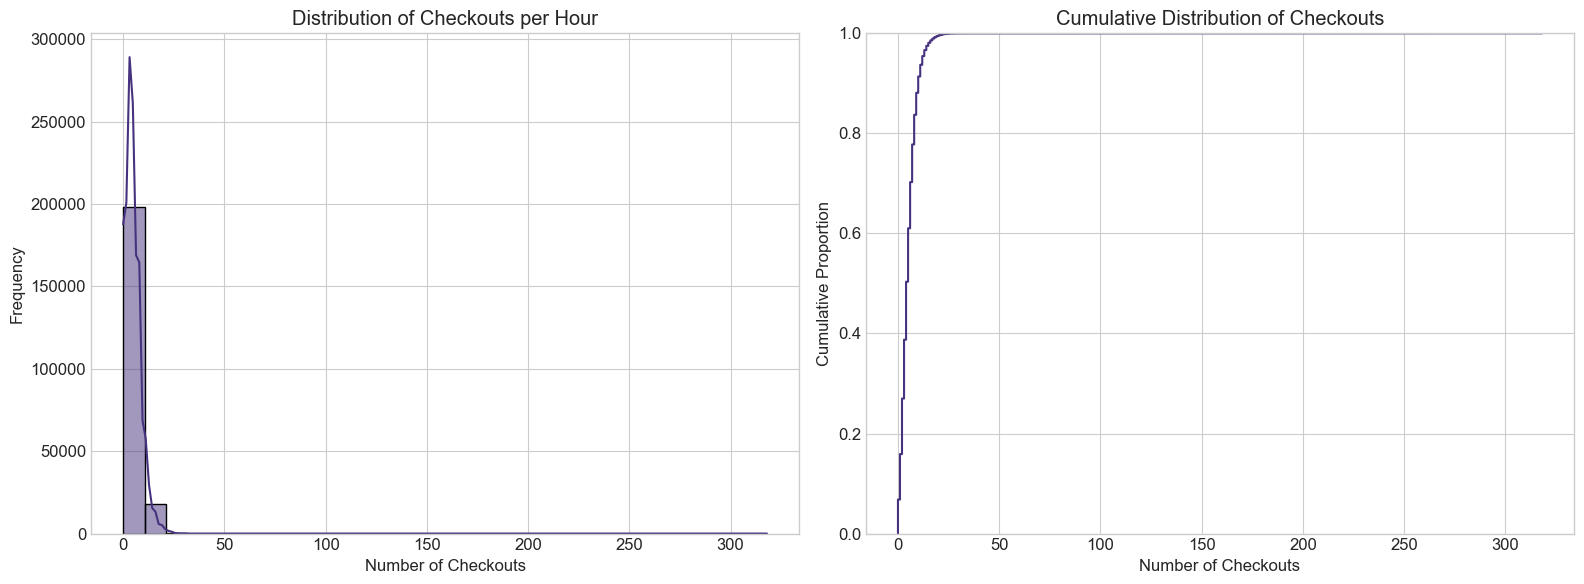

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of the target variable
sns.histplot(merged_final_df['checkouts_hour_station'], bins=30, kde=True, ax=ax1)
ax1.set_title('Distribution of Checkouts per Hour')
ax1.set_xlabel('Number of Checkouts')
ax1.set_ylabel('Frequency')

# Cumulative distribution (ECDF plot)
sns.ecdfplot(merged_final_df['checkouts_hour_station'], ax=ax2)
ax2.set_title('Cumulative Distribution of Checkouts')
ax2.set_xlabel('Number of Checkouts')
ax2.set_ylabel('Cumulative Proportion')
ax2.grid(True)

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

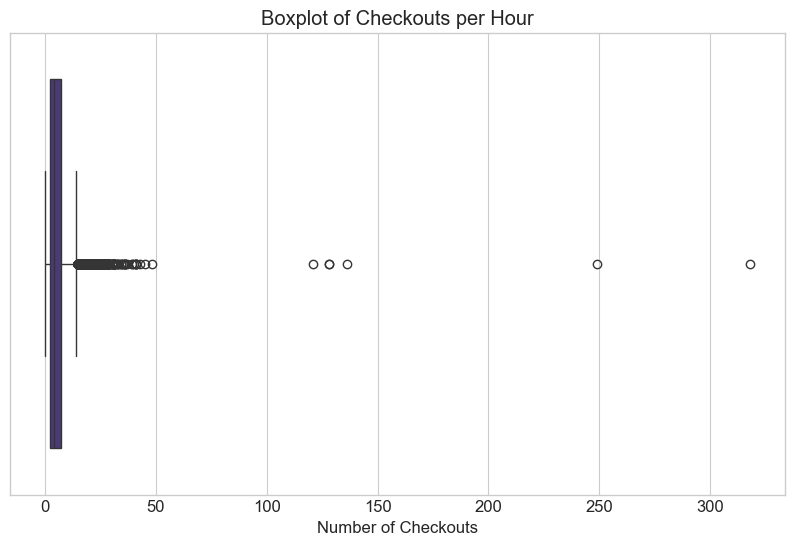

In [144]:
# Boxplot of target variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_final_df['checkouts_hour_station'])
plt.title('Boxplot of Checkouts per Hour')
plt.xlabel('Number of Checkouts')
plt.savefig('target_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

The target varibale distribution is right-skewed so we can benefit from log transfromation. Before we do it, we'll also remove the extreme outliers that are likely due to data errors. 

In [145]:

# Remove extreme outliers (> 100)
extreme_outliers = merged_final_df[merged_final_df['checkouts_hour_station'] > 100]
merged_final_df = merged_final_df[merged_final_df['checkouts_hour_station'] <= 100].copy()


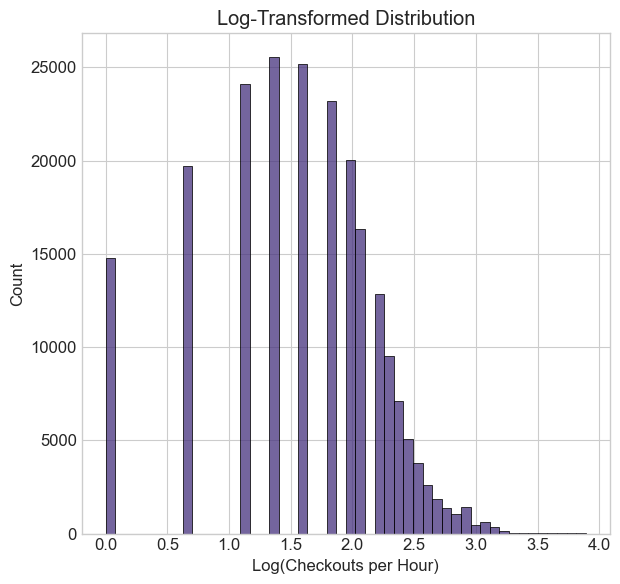

In [146]:
# Apply log transformation 
merged_final_df['log_checkouts'] = np.log1p(merged_final_df['checkouts_hour_station'])


plt.figure(figsize=(18, 6))

# Log-transformed distribution
plt.subplot(1, 3, 3)
sns.histplot(merged_final_df['log_checkouts'], bins=50)
plt.title('Log-Transformed Distribution')
plt.xlabel('Log(Checkouts per Hour)')

plt.tight_layout()
plt.show()




**Key Insights**

- The data has a right-skewed distribution, with most values clustered at the lower end (mean of 5.13 is higher than the median of 4.0).

- The typical checkout rate is between 2 and 7 checkouts per hour per station (25th to 75th percentile range).

- The median of 4.0 suggests that in most hours, stations experience about 4 checkouts.

- The data suggests that planning for handling up to 7-10 checkouts per hour would cover the majority of cases (over 91% of observations).

## **Key Patterns**


Average Checkouts by Hour:
Hour 0: 3.13 avg checkouts
Hour 1: 2.42 avg checkouts
Hour 2: 1.98 avg checkouts
Hour 3: 1.78 avg checkouts
Hour 4: 2.50 avg checkouts
Hour 5: 3.95 avg checkouts
Hour 6: 5.32 avg checkouts
Hour 7: 5.23 avg checkouts
Hour 8: 4.76 avg checkouts
Hour 9: 4.90 avg checkouts
Hour 10: 5.23 avg checkouts
Hour 11: 5.79 avg checkouts
Hour 12: 6.24 avg checkouts
Hour 13: 6.55 avg checkouts
Hour 14: 6.49 avg checkouts
Hour 15: 6.70 avg checkouts
Hour 16: 7.26 avg checkouts
Hour 17: 7.39 avg checkouts
Hour 18: 7.29 avg checkouts
Hour 19: 6.71 avg checkouts
Hour 20: 5.87 avg checkouts
Hour 21: 5.70 avg checkouts
Hour 22: 5.44 avg checkouts
Hour 23: 4.33 avg checkouts


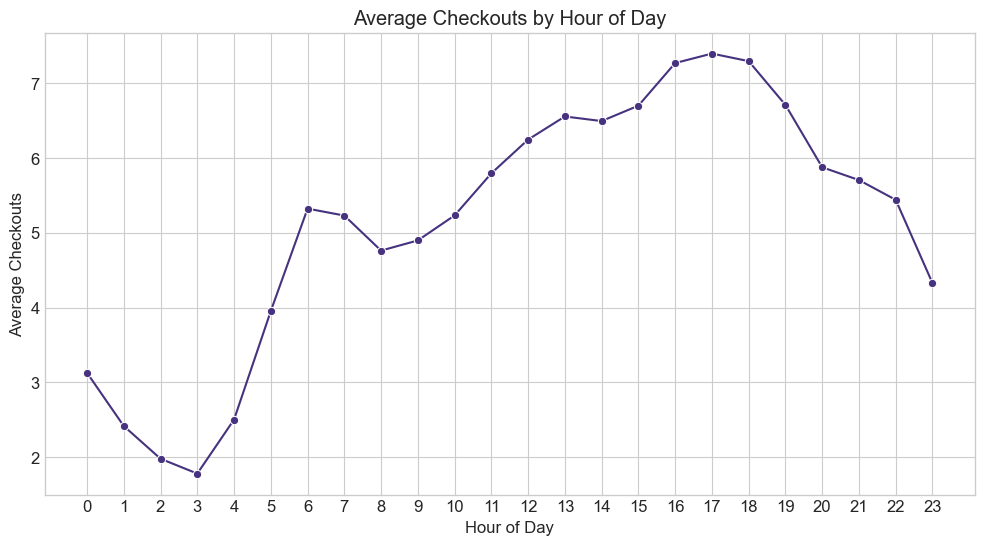

In [147]:
hourly_checkouts = merged_final_df.groupby('hour_of_day')['checkouts_hour_station'].mean().reset_index()
print("\nAverage Checkouts by Hour:")
for _, row in hourly_checkouts.iterrows():
    print(f"Hour {int(row['hour_of_day'])}: {row['checkouts_hour_station']:.2f} avg checkouts")

plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_of_day', y='checkouts_hour_station', data=hourly_checkouts, marker='o')
plt.title('Average Checkouts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Checkouts')
plt.xticks(range(0, 24))
plt.grid(True)


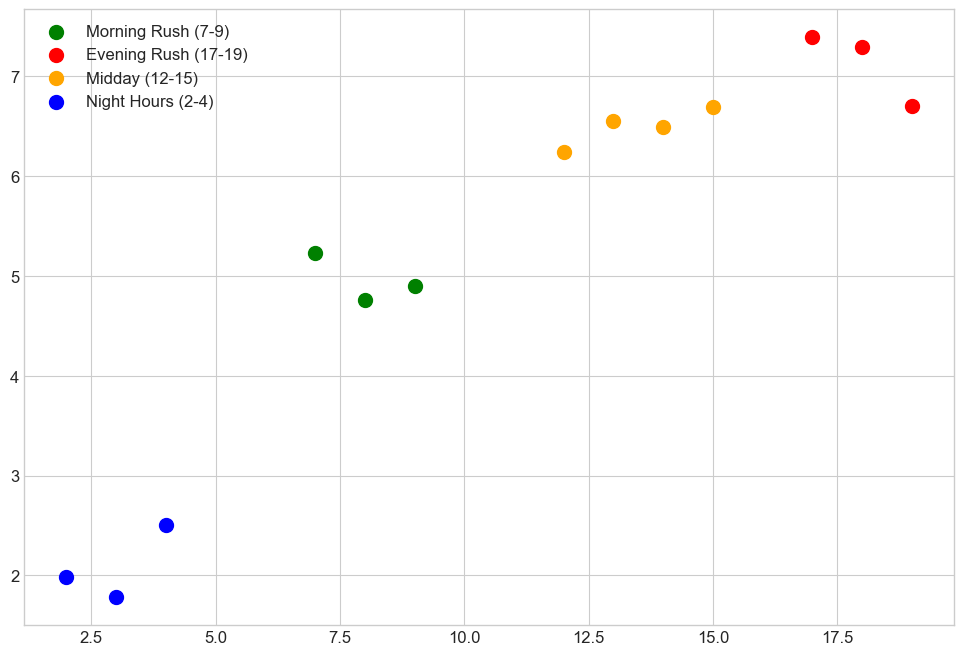

In [148]:
# Highlight rush hours
rush_hours_morning = hourly_checkouts[(hourly_checkouts['hour_of_day'] >= 7) & (hourly_checkouts['hour_of_day'] <= 9)]
rush_hours_evening = hourly_checkouts[(hourly_checkouts['hour_of_day'] >= 17) & (hourly_checkouts['hour_of_day'] <= 19)]
midday_hours = hourly_checkouts[(hourly_checkouts['hour_of_day'] >= 12) & (hourly_checkouts['hour_of_day'] <= 15)]
night_hours = hourly_checkouts[(hourly_checkouts['hour_of_day'] >= 2) & (hourly_checkouts['hour_of_day'] <= 4)]

plt.scatter(rush_hours_morning['hour_of_day'], rush_hours_morning['checkouts_hour_station'], color='green', s=100, label='Morning Rush (7-9)')
plt.scatter(rush_hours_evening['hour_of_day'], rush_hours_evening['checkouts_hour_station'], color='red', s=100, label='Evening Rush (17-19)')
plt.scatter(midday_hours['hour_of_day'], midday_hours['checkouts_hour_station'], color='orange', s=100, label='Midday (12-15)')
plt.scatter(night_hours['hour_of_day'], night_hours['checkouts_hour_station'], color='blue', s=100, label='Night Hours (2-4)')

plt.legend()
plt.savefig('hourly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

In [149]:
# Weekday vs Weekend Analysis
merged_final_df['is_weekend'] = merged_final_df['day_of_week'].isin([0, 6]).astype(int)
weekday_vs_weekend = merged_final_df.groupby('is_weekend')['checkouts_hour_station'].mean().reset_index()
print("\nWeekday vs Weekend Average Checkouts:")
print(f"Weekday: {weekday_vs_weekend.loc[weekday_vs_weekend['is_weekend'] == 0, 'checkouts_hour_station'].values[0]:.2f}")
print(f"Weekend: {weekday_vs_weekend.loc[weekday_vs_weekend['is_weekend'] == 1, 'checkouts_hour_station'].values[0]:.2f}")


Weekday vs Weekend Average Checkouts:
Weekday: 5.30
Weekend: 4.68


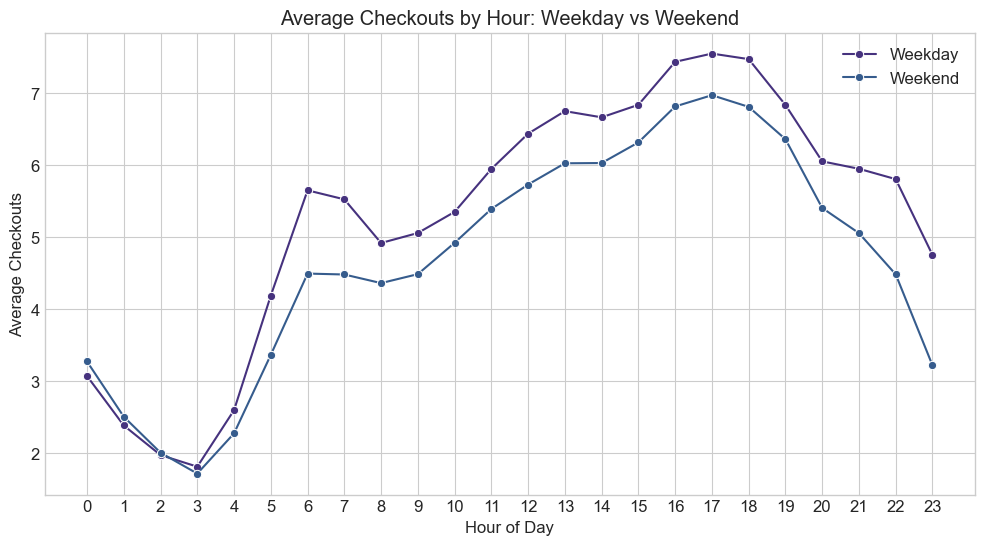

In [150]:
# Hourly pattern by weekday/weekend
hourly_weekday_weekend = merged_final_df.groupby(['hour_of_day', 'is_weekend'])['checkouts_hour_station'].mean().reset_index()
hourly_weekday_weekend['day_type'] = hourly_weekday_weekend['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_of_day', y='checkouts_hour_station', hue='day_type', data=hourly_weekday_weekend, marker='o')
plt.title('Average Checkouts by Hour: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Checkouts')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='')
plt.savefig('weekday_weekend_hourly.png', dpi=300, bbox_inches='tight')
plt.show()


Average Checkouts by Day of Week:
Sunday: 5.03 avg checkouts
Monday: 5.28 avg checkouts
Tuesday: 5.23 avg checkouts
Wednesday: 5.39 avg checkouts
Thursday: 5.54 avg checkouts
Friday: 5.05 avg checkouts
Saturday: 4.33 avg checkouts


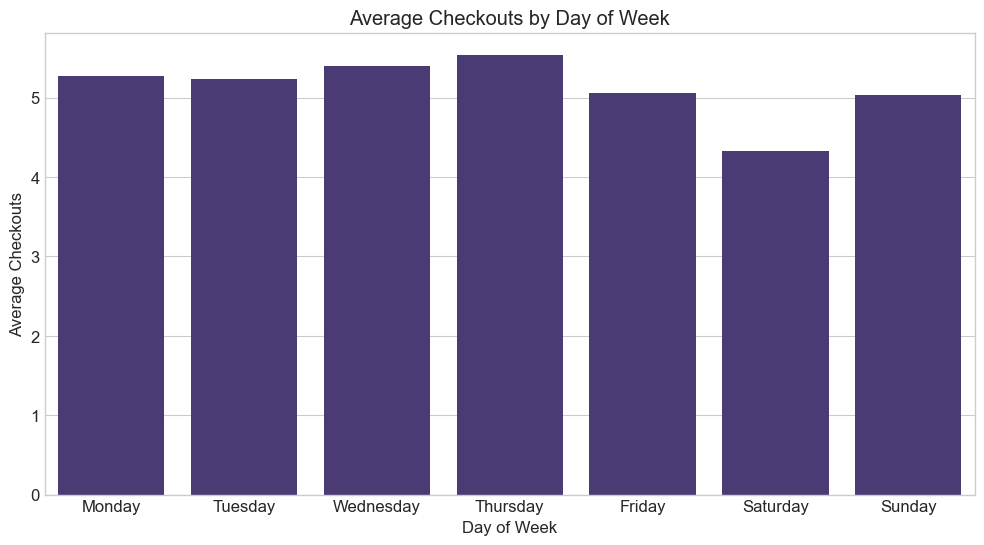

In [151]:
# Daily Pattern
daily_checkouts = merged_final_df.groupby('day_of_week')['checkouts_hour_station'].mean().reset_index()
daily_checkouts['day_name'] = daily_checkouts['day_of_week'].map({
    0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 
    4: 'Thursday', 5: 'Friday', 6: 'Saturday'
})

print("\nAverage Checkouts by Day of Week:")
for _, row in daily_checkouts.iterrows():
    print(f"{row['day_name']}: {row['checkouts_hour_station']:.2f} avg checkouts")

plt.figure(figsize=(12, 6))
sns.barplot(x='day_name', y='checkouts_hour_station', data=daily_checkouts, 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Checkouts by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Checkouts')
plt.grid(True, axis='y')
plt.savefig('daily_pattern.png', dpi=300, bbox_inches='tight')
plt.show()



Average Checkouts by Month:
Jan: 4.75 avg checkouts
Jul: 3.07 avg checkouts
Aug: 4.99 avg checkouts
Sep: 5.48 avg checkouts
Oct: 5.64 avg checkouts
Nov: 5.43 avg checkouts
Dec: 4.51 avg checkouts


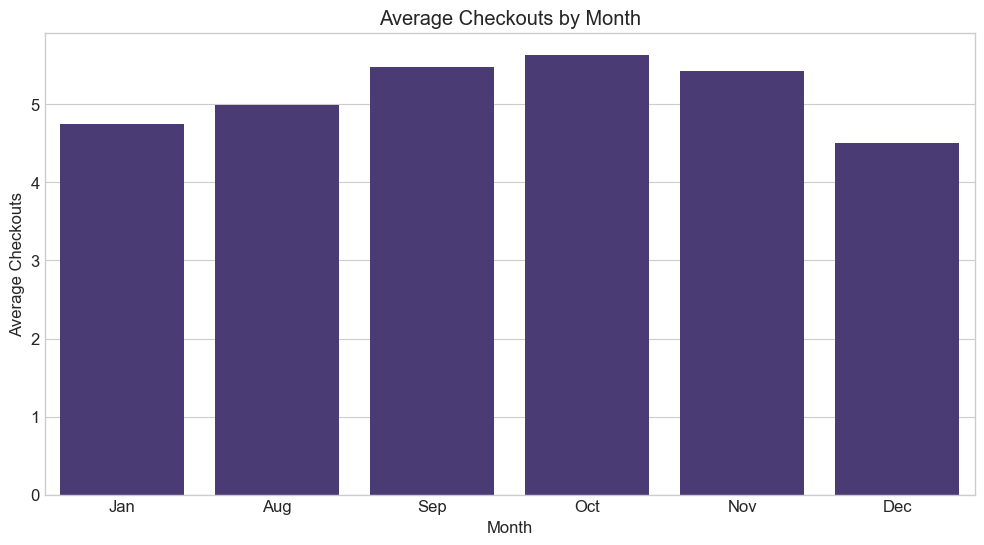

In [152]:
# Monthly Pattern
monthly_checkouts = merged_final_df.groupby('month')['checkouts_hour_station'].mean().reset_index()
monthly_checkouts['month_name'] = monthly_checkouts['month'].map({
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
})

print("\nAverage Checkouts by Month:")
for _, row in monthly_checkouts.iterrows():
    print(f"{row['month_name']}: {row['checkouts_hour_station']:.2f} avg checkouts")

plt.figure(figsize=(12, 6))
sns.barplot(x='month_name', y='checkouts_hour_station', data=monthly_checkouts,
            order=['Jan', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Average Checkouts by Month')
plt.xlabel('Month')
plt.ylabel('Average Checkouts')
plt.grid(True, axis='y')
plt.savefig('monthly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()


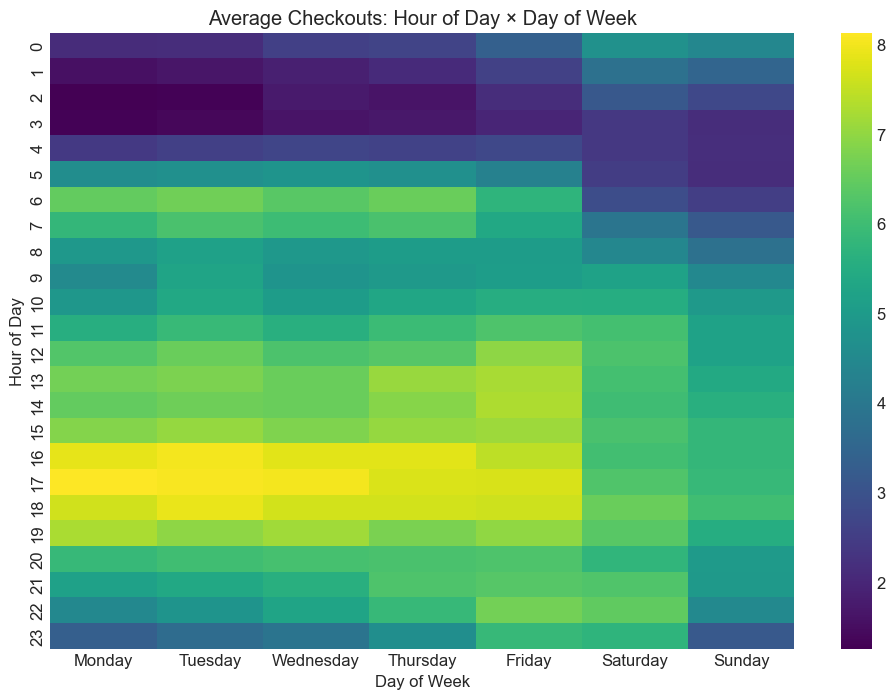

In [153]:
# Create pivot table: rows are hours of day, columns are day_of_week, values are the average checkouts
pivot_hour_day = merged_final_df.pivot_table(
    values='checkouts_hour_station', 
    index='hour_of_day', 
    columns='day_of_week', 
    aggfunc='mean'
)

day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 
               3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
pivot_hour_day.rename(columns=day_mapping, inplace=True)


ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_hour_day = pivot_hour_day.reindex(columns=ordered_days)

pivot_hour_day = pivot_hour_day.astype(float)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_hour_day, cmap='viridis', annot=False, fmt='.1f')
plt.title('Average Checkouts: Hour of Day × Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.savefig('hour_day_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

**Key Isnight & Observations**

- Hourly Peaks: Strong morning (7–9) and evening (17–19) peaks on weekdays. Flatter weekend usage with midday rise.
- Weekday vs. Weekend: Weekdays - Two clear commute peaks. Weekends: More distributed usage.
- Day-of-Week Variation: Friday might have higher evening usage. Monday–Thursday exhibit similar patterns.
- Seasonality by Month: Higher demand in September/October, lower in winter months (e.g., December).


## **Weather Impact**


Average Checkouts by Temperature Range:
< 0°C: 2.89 avg checkouts (3297 samples)
0-5°C: 3.61 avg checkouts (14874 samples)
5-10°C: 4.29 avg checkouts (37230 samples)
10-15°C: 5.18 avg checkouts (51929 samples)
15-20°C: 5.47 avg checkouts (50423 samples)
20-25°C: 5.61 avg checkouts (37221 samples)
25-30°C: 6.26 avg checkouts (16911 samples)
> 30°C: 5.87 avg checkouts (5167 samples)


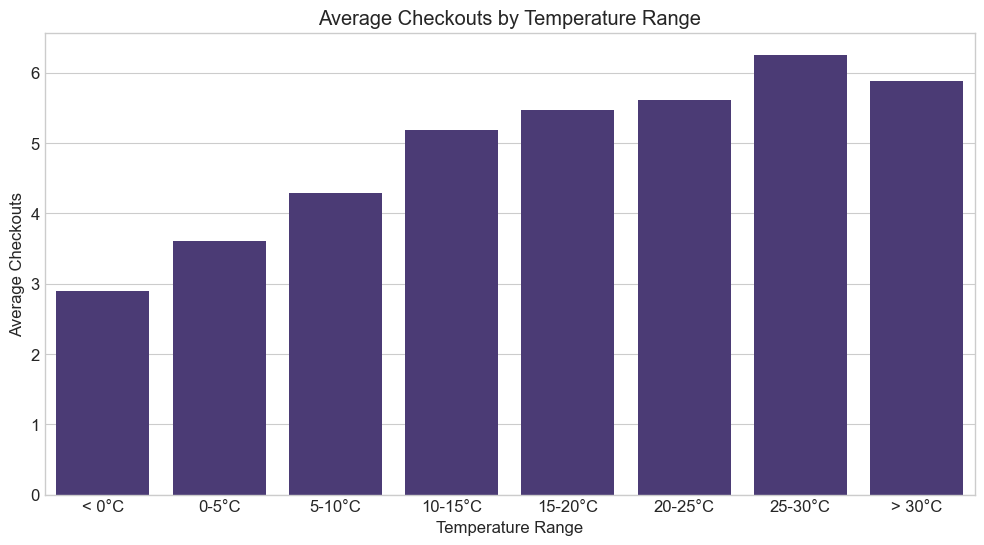

In [154]:
# Temperature impact
# Create temperature bins
temp_bins = [-10, 0, 5, 10, 15, 20, 25, 30, 40]
temp_labels = ['< 0°C', '0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C', '> 30°C']
merged_final_df['temp_category'] = pd.cut(merged_final_df['temperature'], bins=temp_bins, labels=temp_labels)

temp_impact = merged_final_df.groupby('temp_category')['checkouts_hour_station'].agg(['mean', 'count']).reset_index()
print("\nAverage Checkouts by Temperature Range:")
for _, row in temp_impact.iterrows():
    print(f"{row['temp_category']}: {row['mean']:.2f} avg checkouts ({row['count']} samples)")

plt.figure(figsize=(12, 6))
sns.barplot(x='temp_category', y='mean', data=temp_impact)
plt.title('Average Checkouts by Temperature Range')
plt.xlabel('Temperature Range')
plt.ylabel('Average Checkouts')
plt.grid(True, axis='y')
plt.savefig('temperature_impact.png', dpi=300, bbox_inches='tight')
plt.show()


Average Checkouts by Precipitation Level:
No rain: 5.12 avg checkouts (189360 samples)
Light rain: 5.41 avg checkouts (11384 samples)
Moderate rain: 4.60 avg checkouts (3181 samples)
Heavy rain: 5.88 avg checkouts (597 samples)


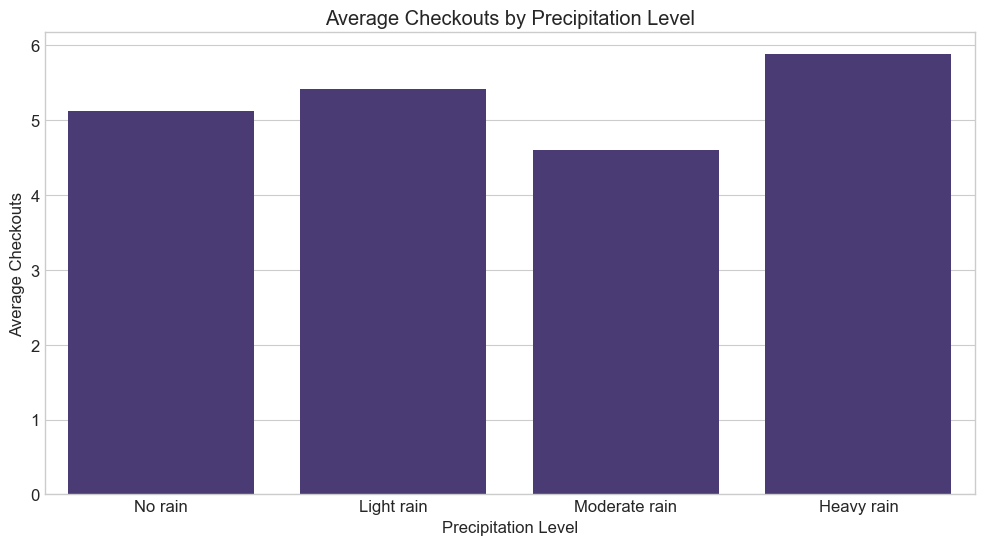

In [155]:
# Precipitation impact
# Create precipitation bins
precip_bins = [-0.1, 0, 1, 5, 100]
precip_labels = ['No rain', 'Light rain', 'Moderate rain', 'Heavy rain']

merged_final_df['precip_category'] = pd.cut(
    merged_final_df['precipitation'], 
    bins=precip_bins, 
    labels=precip_labels
)

precip_impact = merged_final_df.groupby('precip_category')['checkouts_hour_station'].agg(['mean', 'count']).reset_index()
print("\nAverage Checkouts by Precipitation Level:")
for _, row in precip_impact.iterrows():
    print(f"{row['precip_category']}: {row['mean']:.2f} avg checkouts ({row['count']} samples)")

plt.figure(figsize=(12, 6))
sns.barplot(x='precip_category', y='mean', data=precip_impact)
plt.title('Average Checkouts by Precipitation Level')
plt.xlabel('Precipitation Level')
plt.ylabel('Average Checkouts')
plt.grid(True, axis='y')
plt.savefig('precipitation_impact.png', dpi=300, bbox_inches='tight')
plt.show()



Average Checkouts by Weather Category:
clear: 5.13 avg checkouts (112232 samples)
cloudy: 5.13 avg checkouts (87465 samples)
rain: 4.83 avg checkouts (12479 samples)
storm: 5.81 avg checkouts (4876 samples)


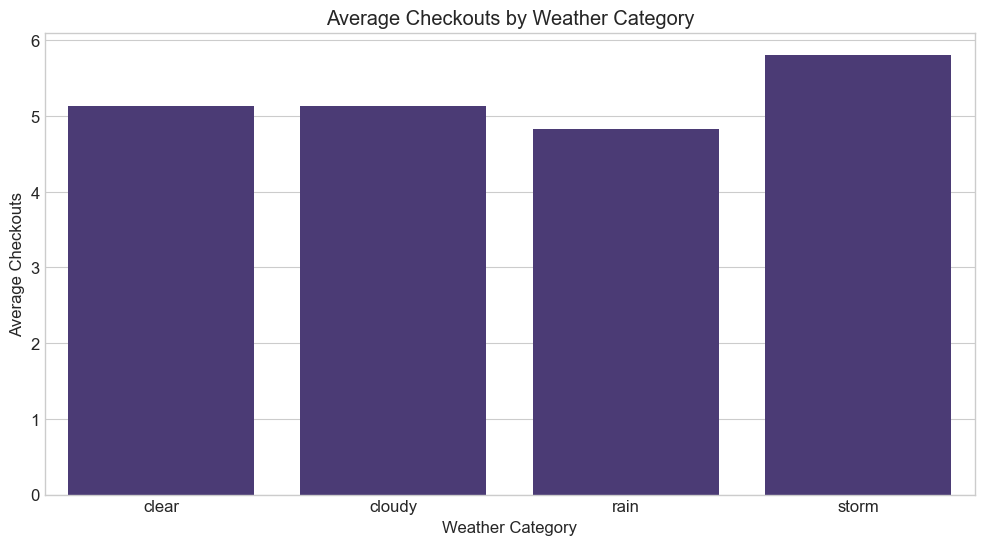

In [156]:
# Weather category impact
weather_impact = merged_final_df.groupby('weather_category')['checkouts_hour_station'].agg(['mean', 'count']).reset_index()
print("\nAverage Checkouts by Weather Category:")
for _, row in weather_impact.iterrows():
    print(f"{row['weather_category']}: {row['mean']:.2f} avg checkouts ({row['count']} samples)")

plt.figure(figsize=(12, 6))
sns.barplot(x='weather_category', y='mean', data=weather_impact)
plt.title('Average Checkouts by Weather Category')
plt.xlabel('Weather Category')
plt.ylabel('Average Checkouts')
plt.grid(True, axis='y')
plt.savefig('weather_category_impact.png', dpi=300, bbox_inches='tight')
plt.show()

**Key Insights**

- Gradual Increase in Checkouts with Rising Temperatures. Temperature looks highly predictive. Including temperature (and possibly a non-linear transformation) can imporve accuracy of our model. We can use temperature as a continuous numeric feature or temperature bins as categorical variables.

- The bar chart indicates that no rain corresponds to higher average checkouts, and usage drops off with increasing precipitation intensity (light → moderate → heavy).We can encode precipitation as a numeric feature (mm of rainfall) or a categorical feature (none, light, moderate, heavy). We should expect a strong negative correlation between heavier precipitation and checkouts.

- Clear weather: Highest average checkouts, comparable to the “no rain” scenario. Rain and Storm: Sharply reduced checkouts.Cloudy: Somewhere in between clear and rainy—slightly lower usage than clear, but not as low as rain or storm. A categorical weather condition feature (clear, cloudy, rain, storm) can add interpretability and might capture nuances beyond raw temperature and precipitation data.



## **Correlations & Feature Importance**


Correlations with checkouts_hour_station:
checkouts_hour_station          1.000000
checkouts_hour_station_lag24    0.354327
hour_of_day                     0.317572
checkouts_hour_station_lag1     0.314813
temperature                     0.181704
wind_speed                      0.144044
num_bikes_available_mean        0.060510
month                           0.029593
precipitation                  -0.003007
day_of_week                    -0.041570
num_docks_available_mean       -0.067730
Name: checkouts_hour_station, dtype: float64


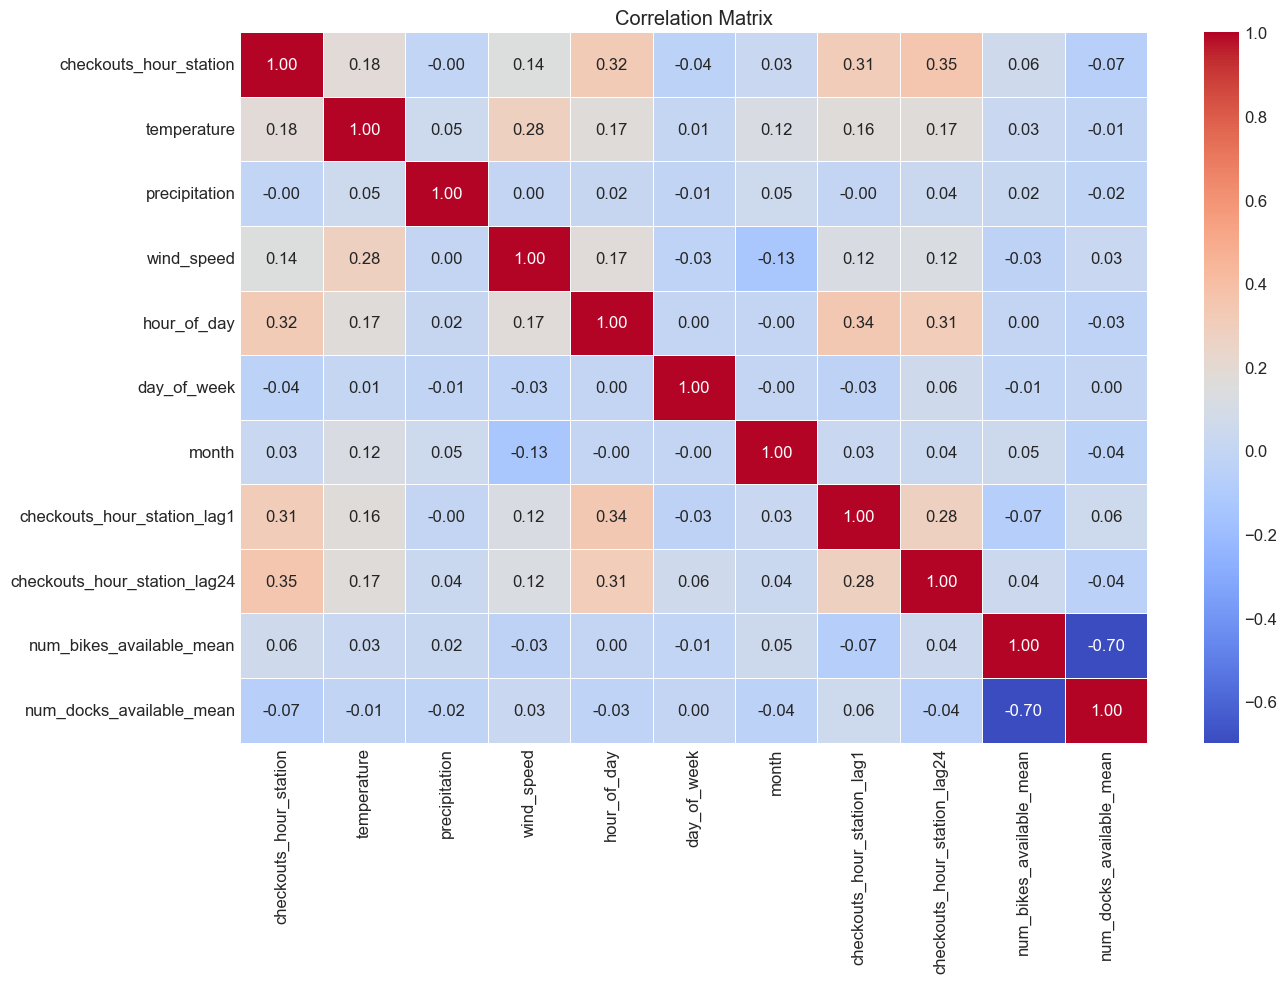

In [157]:
# Select numerical columns for correlation analysis
numerical_cols = ['checkouts_hour_station', 'temperature', 'precipitation', 'wind_speed',
                 'hour_of_day', 'day_of_week', 'month', 'checkouts_hour_station_lag1', 
                 'checkouts_hour_station_lag24', 'num_bikes_available_mean', 'num_docks_available_mean']

# Compute the correlation matrix
corr_matrix = merged_final_df[numerical_cols].corr()
# Print correlations with target
corr_with_target = corr_matrix['checkouts_hour_station'].sort_values(ascending=False)
print("\nCorrelations with checkouts_hour_station:")
print(corr_with_target)

# Plot the correlation matrix heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


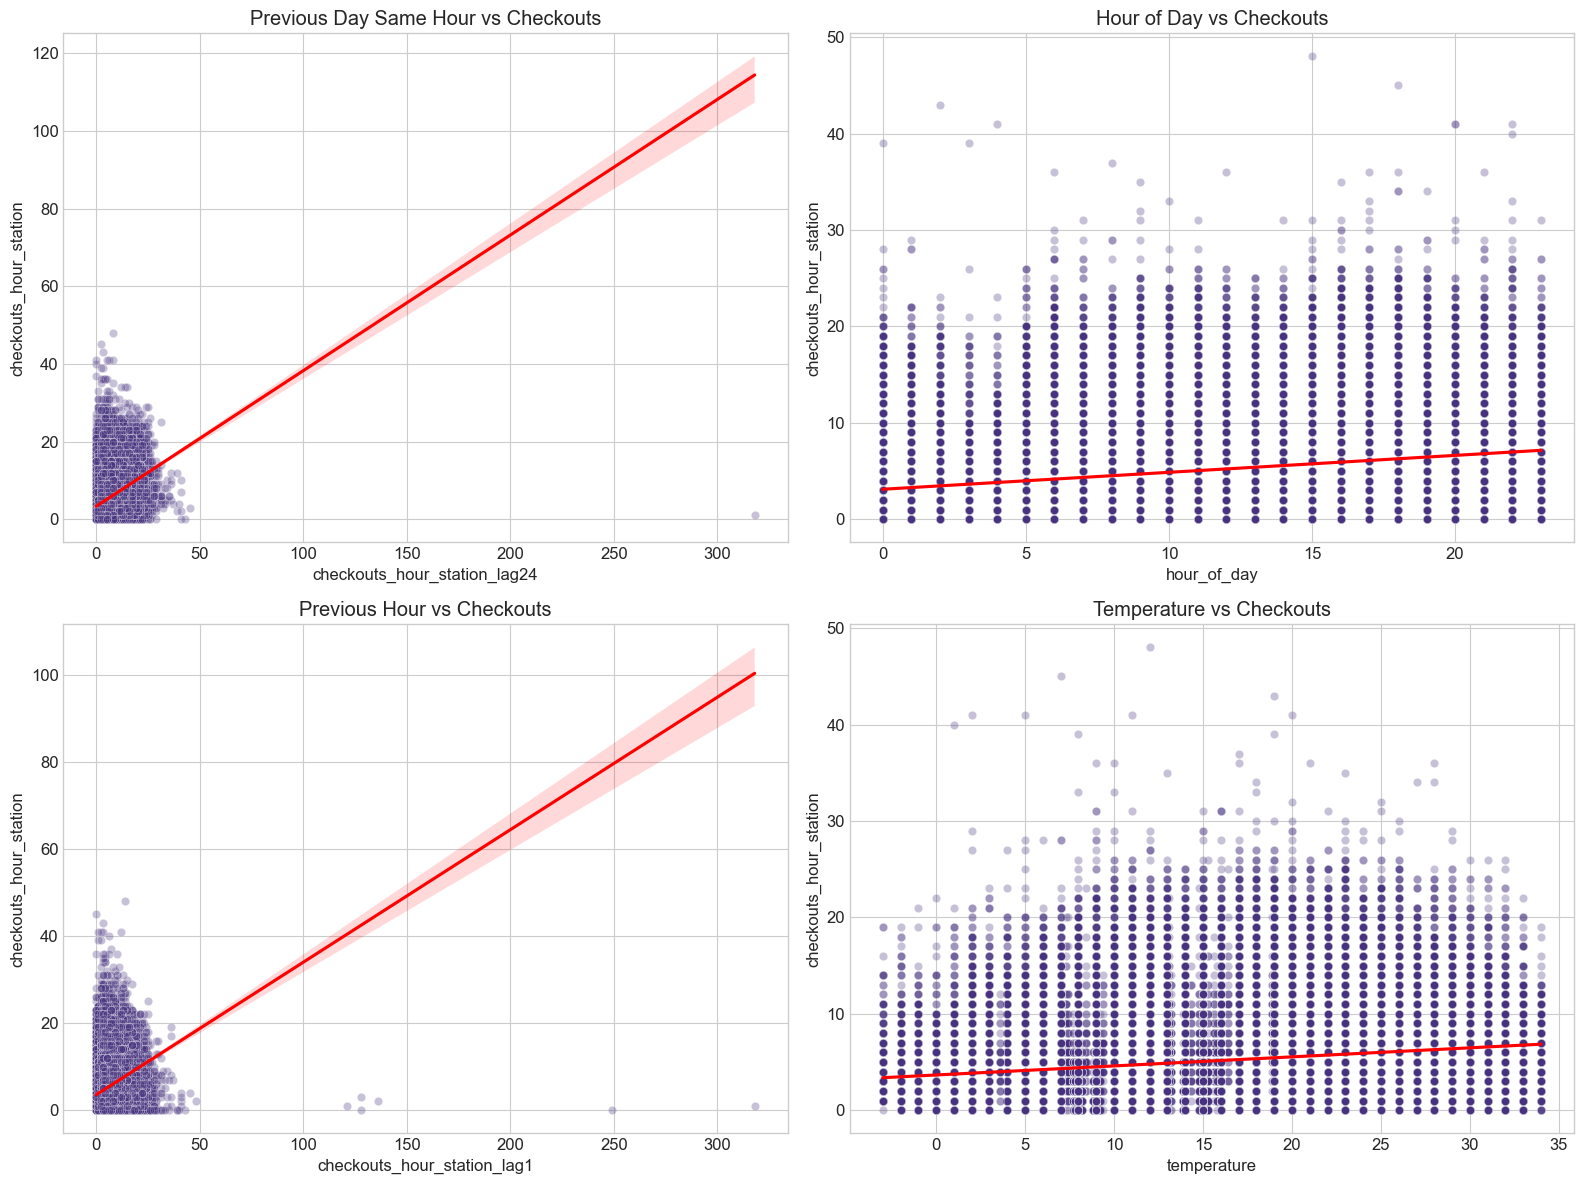

In [158]:
# Scatter plots for strongest correlations
df_copy = merged_final_df.copy().reset_index(drop=True)
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Lag24 vs Checkouts
sns.scatterplot(x='checkouts_hour_station_lag24', y='checkouts_hour_station', data=df_copy, alpha=0.3, ax=axs[0, 0])
axs[0, 0].set_title('Previous Day Same Hour vs Checkouts')
axs[0, 0].set_xlabel('Previous Day Checkouts')
axs[0, 0].set_ylabel('Current Hour Checkouts')
sns.regplot(x='checkouts_hour_station_lag24', y='checkouts_hour_station', data=df_copy, scatter=False, ax=axs[0, 0], color='red')

# Hour vs Checkouts
sns.scatterplot(x='hour_of_day', y='checkouts_hour_station', data=df_copy, alpha=0.3, ax=axs[0, 1])
axs[0, 1].set_title('Hour of Day vs Checkouts')
axs[0, 1].set_xlabel('Hour of Day')
axs[0, 1].set_ylabel('Checkouts')
sns.regplot(x='hour_of_day', y='checkouts_hour_station', data=df_copy, scatter=False, ax=axs[0, 1], color='red')

# Lag1 vs Checkouts
sns.scatterplot(x='checkouts_hour_station_lag1', y='checkouts_hour_station', data=df_copy, alpha=0.3, ax=axs[1, 0])
axs[1, 0].set_title('Previous Hour vs Checkouts')
axs[1, 0].set_xlabel('Previous Hour Checkouts')
axs[1, 0].set_ylabel('Current Hour Checkouts')
sns.regplot(x='checkouts_hour_station_lag1', y='checkouts_hour_station', data=df_copy, scatter=False, ax=axs[1, 0], color='red')

# Temperature vs Checkouts
sns.scatterplot(x='temperature', y='checkouts_hour_station', data=df_copy, alpha=0.3, ax=axs[1, 1])
axs[1, 1].set_title('Temperature vs Checkouts')
axs[1, 1].set_xlabel('Temperature (°C)')
axs[1, 1].set_ylabel('Checkouts')
sns.regplot(x='temperature', y='checkouts_hour_station', data=df_copy, scatter=False, ax=axs[1, 1], color='red')

plt.tight_layout()
plt.savefig('correlation_scatterplots.png', dpi=300, bbox_inches='tight')
plt.show()


**Key Insights**

- Lag features stand out as the most critical for predicting hourly checkouts.
- Time-of-day and day-of-week strongly shape demand patterns.
- Weather features (temp, precipitation, wind) add valuable context, especially in certain temperature/rain thresholds.
- We can consider combine these features and apply a time-series-aware validation approach to build a robust model. 

## **Missing Values & Data types analysis**

In [159]:
# Missing values
missing_values = merged_final_df.isnull().sum()
missing_pct = (merged_final_df.isnull().sum() / len(merged_final_df)) * 100
missing_merged_final_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_pct})
missing_merged_final_df = missing_merged_final_df[missing_merged_final_df['Missing Values'] > 0].sort_values('Percentage', ascending=False)

print("\nMissing Values:")
print(missing_merged_final_df)


Missing Values:
                              Missing Values  Percentage
precipitation                          12680    5.837884
precip_category                        12680    5.837884
checkouts_hour_station_lag24            1200    0.552481
temperature                              150    0.069060
wind_speed                               150    0.069060
weather_category                         150    0.069060
temp_category                            150    0.069060
checkouts_hour_station_lag1               50    0.023020


In [160]:
# Data types
print("\nData Types:")
print(merged_final_df.dtypes)


Data Types:
station_id                         Int64
num_bikes_available_mean         float64
mechanical_available             float64
ebike_available                  float64
num_docks_available_mean         float64
num_docks_available_max            Int64
is_charging_station                 bool
status                            object
is_installed                       Int64
is_renting                         Int64
is_returning                       Int64
ttl                                Int64
checkouts_hour_station             Int64
temperature                      float64
precipitation                    float64
wind_speed                       float64
weather_category                  object
day_of_week                        int32
hour_of_day                        int32
month                              int32
checkouts_hour_station_lag1        Int64
checkouts_hour_station_lag24       Int64
lat                              float64
lon                              float64
add

In [161]:
# Check is_charging_station values
print("\nis_charging_station value counts:")
print(merged_final_df['is_charging_station'].value_counts())

# Check status values
print("\nStatus value counts:")
print(merged_final_df['status'].value_counts())

# Check weather categories
print("\nWeather category value counts:")
print(merged_final_df['weather_category'].value_counts())


is_charging_station value counts:
is_charging_station
True    217202
Name: count, dtype: int64

Status value counts:
status
IN_SERVICE     216908
MAINTENANCE       294
Name: count, dtype: int64

Weather category value counts:
weather_category
clear     112232
cloudy     87465
rain       12479
storm       4876
Name: count, dtype: int64


In [162]:
#Group by station to identify high vs low traffic stations
station_activity = merged_final_df.groupby('station_id')['checkouts_hour_station'].agg(['mean', 'max', 'count']).reset_index()
station_activity = station_activity.sort_values('mean', ascending=False)

print("\nTop 10 Highest Traffic Stations:")
print(station_activity.head(10))

print("\nBottom 10 Lowest Traffic Stations:")
print(station_activity.tail(10))


Top 10 Highest Traffic Stations:
    station_id      mean  max  count
4           42  7.388338   36   4339
40         364  6.438318   33   4280
2           29   6.14638   25   4379
13          80  6.078068   22   4368
44         390  5.977834   27   4376
39         362  5.970259   45   4203
30         220  5.728477   28   4379
10          73  5.535001   48   4357
22         118  5.459775   31   4363
0           24  5.417321   30   4203

Bottom 10 Lowest Traffic Stations:
    station_id      mean  max  count
9           72  4.626685   26   4377
18         106  4.593712   28   4103
6           61  4.572734   22   4379
17          94  4.555938   41   4362
19         107  4.485956   23   4379
7           65  4.460379   25   4379
26         149  4.356702   26   4379
46         414  4.335252   35   4343
36         230  3.817767   26   4379
16          89  3.264444   22   4379


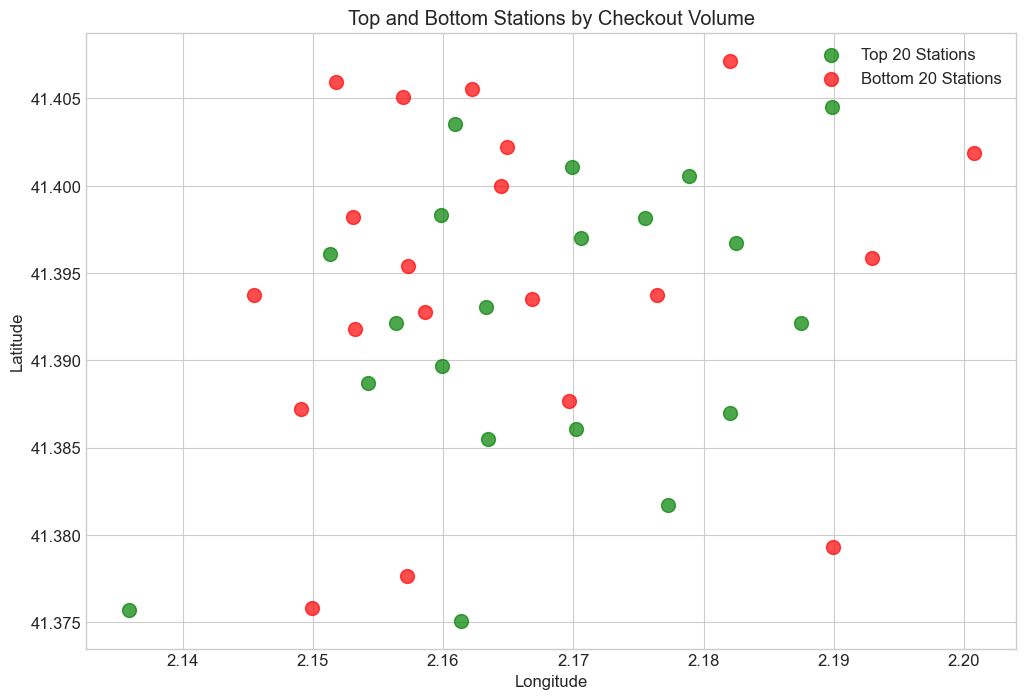

In [163]:
# Merge station coordinates
station_coords = merged_final_df[['station_id', 'lat', 'lon', 'address']].drop_duplicates()
station_activity = station_activity.merge(station_coords, on='station_id')

# Plot top and bottom stations
plt.figure(figsize=(12, 8))
plt.scatter(station_activity.head(20)['lon'], station_activity.head(20)['lat'], s=100, 
            c='green', alpha=0.7, label='Top 20 Stations')
plt.scatter(station_activity.tail(20)['lon'], station_activity.tail(20)['lat'], s=100, 
            c='red', alpha=0.7, label='Bottom 20 Stations')
plt.title('Top and Bottom Stations by Checkout Volume')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.savefig('top_bottom_stations.png', dpi=300, bbox_inches='tight')
plt.show()


Checkouts by Proximity to City Center:
very_central: 5.21 avg checkouts (9 stations)
central: 5.15 avg checkouts (29 stations)
mid_distance: 5.02 avg checkouts (12 stations)
outskirts: <NA> avg checkouts (0 stations)


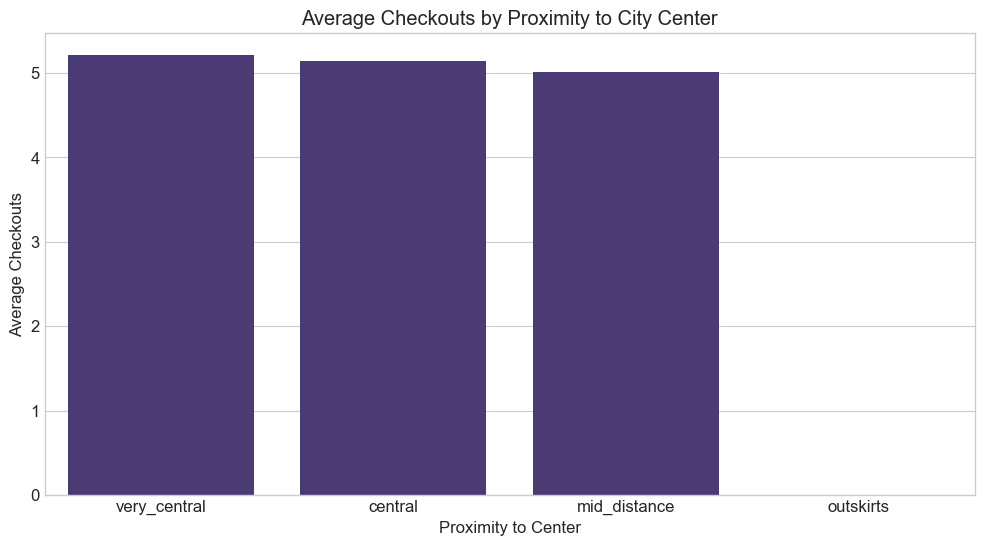

In [164]:
# Calculate distance to city center
BARCELONA_CENTER_LAT = 41.3874
BARCELONA_CENTER_LON = 2.1686

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    a = np.sin(dLat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dLon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

station_activity['distance_to_center'] = station_activity.apply(
    lambda row: haversine_distance(row['lat'], row['lon'], BARCELONA_CENTER_LAT, BARCELONA_CENTER_LON), 
    axis=1
)

# Group stations by distance to center
station_activity['proximity'] = pd.cut(
    station_activity['distance_to_center'],
    bins=[0, 1, 2, 4, 100],
    labels=['very_central', 'central', 'mid_distance', 'outskirts']
)

proximity_stats = station_activity.groupby('proximity')['mean'].agg(['mean', 'count']).reset_index()
print("\nCheckouts by Proximity to City Center:")
for _, row in proximity_stats.iterrows():
    print(f"{row['proximity']}: {row['mean']:.2f} avg checkouts ({row['count']} stations)")

plt.figure(figsize=(12, 6))
sns.barplot(x='proximity', y='mean', data=proximity_stats)
plt.title('Average Checkouts by Proximity to City Center')
plt.xlabel('Proximity to Center')
plt.ylabel('Average Checkouts')
plt.grid(True, axis='y')
plt.savefig('proximity_impact.png', dpi=300, bbox_inches='tight')
plt.show()

In [165]:
m = folium.Map(location=[41.3874, 2.1686], zoom_start=13)

# Create a heatmap of station activity
heat_data = [[row['lat'], row['lon'], row['mean']] for _, row in station_activity.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)

# Save the map
m

In [166]:
# Create another map with markers for top and bottom stations
m2 = folium.Map(location=[41.3874, 2.1686], zoom_start=13)

# Add markers for top 20 stations
for _, row in station_activity.head(20).iterrows():
    folium.Marker(
        [row['lat'], row['lon']],
        popup=f"Station {row['station_id']}: {row['mean']:.2f} avg checkouts",
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(m2)

# Add markers for bottom 20 stations
for _, row in station_activity.tail(20).iterrows():
    folium.Marker(
        [row['lat'], row['lon']],
        popup=f"Station {row['station_id']}: {row['mean']:.2f} avg checkouts",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m2)


m2

## **Time Series Analysis**

In [167]:
#Ensuring data is chronologically sorted
merged_final_df = merged_final_df.sort_index()

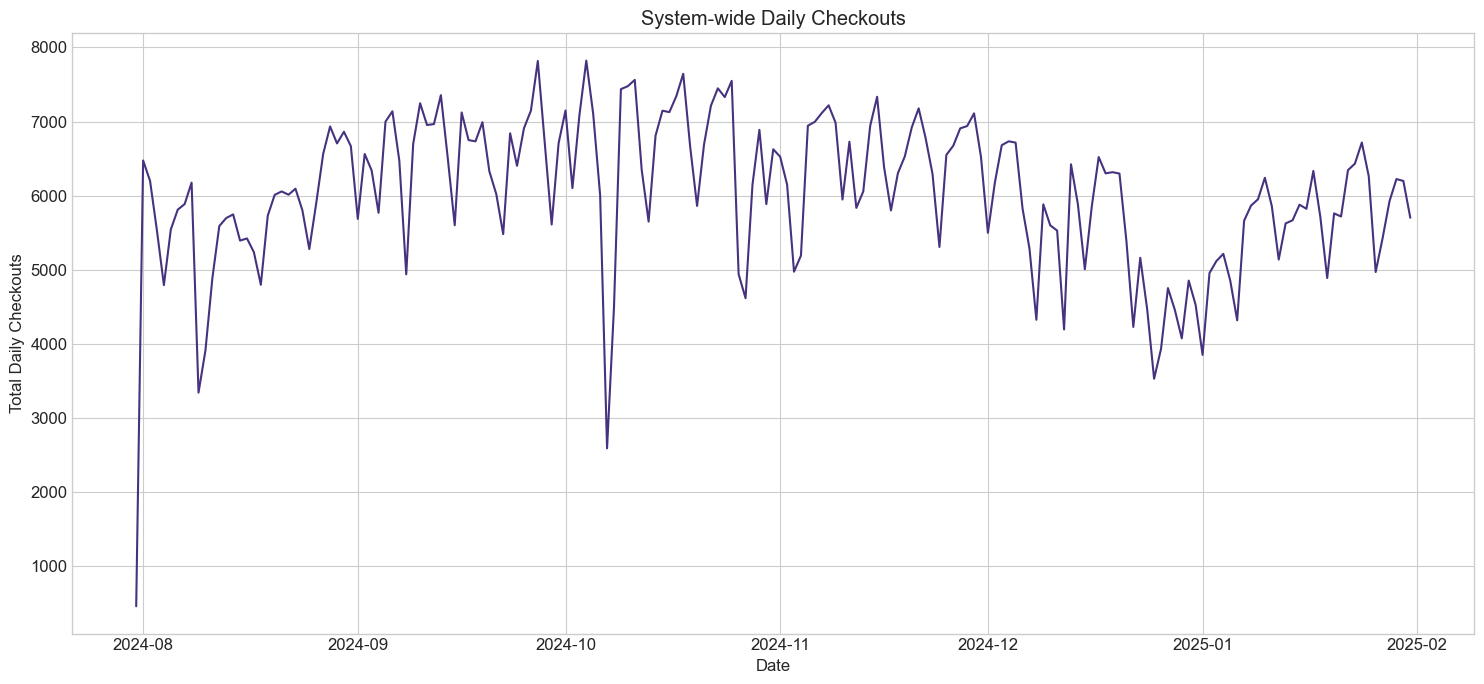

In [168]:
# Aggregate data to system-wide level by date for time series analysis
system_daily = merged_final_df['checkouts_hour_station'].resample('D').sum()

# Plot time series
plt.figure(figsize=(15, 7))
plt.plot(system_daily)
plt.title('System-wide Daily Checkouts')
plt.xlabel('Date')
plt.ylabel('Total Daily Checkouts')
plt.grid(True)
plt.tight_layout()
plt.savefig('time_series_trend.png', dpi=300, bbox_inches='tight')
plt.show()



Performing time series decomposition...


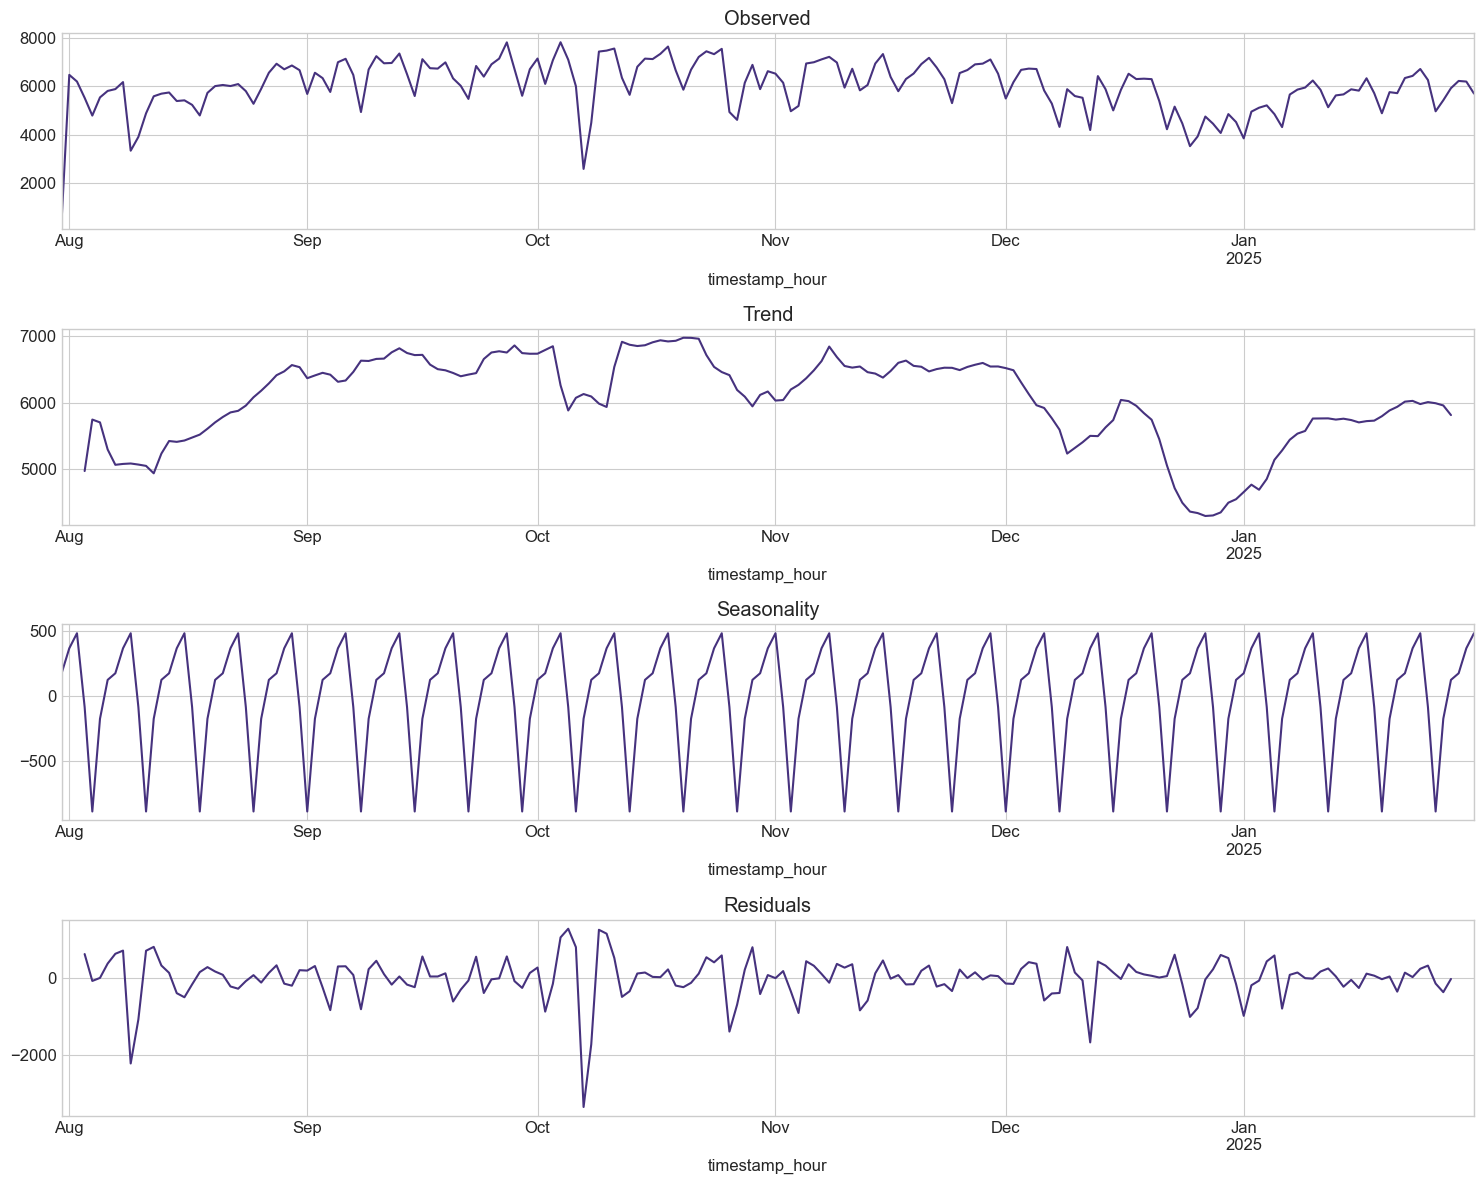

Creating trend and seasonality features from decomposition...


In [169]:
#Trend and Seasonality Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

try:
    print("\nPerforming time series decomposition...")
    # Decompose time series with weekly seasonality
    decomposition = seasonal_decompose(system_daily, model='additive', period=7)  # 7 for weekly patterns

    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    ax1.grid(True)

    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    ax2.grid(True)

    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonality')
    ax3.grid(True)

    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residuals')
    ax4.grid(True)

    plt.tight_layout()
    plt.savefig('time_series_decomposition.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create trend and seasonality features
    print("Creating trend and seasonality features from decomposition...")

    # Map trend and seasonality back to original dataframe
    # First create a Series with date index
    trend_series = decomposition.trend
    seasonal_series = decomposition.seasonal

    # Now map to the original dataframe using the date component of the timestamp index
    merged_final_df['trend'] = merged_final_df.index.map(
        lambda x: trend_series.get(pd.Timestamp(x.date())) if pd.Timestamp(x.date()) in trend_series.index else np.nan
    )

    merged_final_df['seasonality'] = merged_final_df.index.map(
        lambda x: seasonal_series.get(pd.Timestamp(x.date())) if pd.Timestamp(x.date()) in seasonal_series.index else np.nan
    )

except Exception as e:
    print(f"Could not perform seasonal decomposition: {e}")
    print("Proceeding without decomposition-based features")

1.	Observed: The overall daily checkouts seem to hover around a certain range 
2.	Trend: The trend line appears to show a moderate rise or fall over time (depending on the specific portion of the graph). It is relatively smooth compared to the daily fluctuations.
3.	Seasonality: With a period of 7, you can see a clear weekly cycle. The peaks and troughs repeat roughly every 7 days, indicating a consistent day-of-week effect (e.g., weekends vs. weekdays).
4.	Residuals: The residuals capture the random noise or other unexplained variation after accounting for trend and seasonality. We want these to be as close to “white noise” as possible, with no strong autocorrelation left.

In [170]:
## Test for stationarity
def test_stationarity(timeseries, title=''):
    # Perform Dickey-Fuller test
    print(f'\nResults of Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    # Check if stationary based on p-value
    if dftest[1] <= 0.05:
        print("Conclusion: Time series is stationary")
        return True
    else:
        print("Conclusion: Time series is non-stationary")
        return False
# Test stationarity of overall system-wide data
print("\nTesting for stationarity")
is_stationary = test_stationarity(system_daily, 'System-wide Daily Checkouts')


Testing for stationarity

Results of Dickey-Fuller Test for System-wide Daily Checkouts:
Test Statistic                  -1.988738
p-value                          0.291533
#Lags Used                      13.000000
Number of Observations Used    171.000000
Critical Value (1%)             -3.469181
Critical Value (5%)             -2.878595
Critical Value (10%)            -2.575863
dtype: float64
Conclusion: Time series is non-stationary


In [171]:
# For each station, create differenced features
diff_features = []
    
for station, group in merged_final_df.groupby('station_id'):
        # Group is already sorted by timestamp_hour index
        
        # First difference (hour-to-hour)
        group['diff_1h'] = group['checkouts_hour_station'].diff(1)
        
        # Daily difference (same hour previous day)
        group['diff_24h'] = group['checkouts_hour_station'].diff(24)
        
        # Weekly difference (same hour previous week)
        group['diff_168h'] = group['checkouts_hour_station'].diff(168)
        
        # Store the group with new features
        diff_features.append(group)
    
# Recombine data
merged_final_df = pd.concat(diff_features)
    
# Test if the differenced series is now stationary
system_daily_diff = system_daily.diff(1).dropna()
is_diff_stationary = test_stationarity(system_daily_diff, 'First-Differenced System-wide Daily Checkouts')
    
if is_diff_stationary:
    print("First-order differencing successfully achieved stationarity")
else:
    print("Warning: Even after differencing, the time series remains non-stationary")
    print("Consider additional transformations or proceed with caution")



Results of Dickey-Fuller Test for First-Differenced System-wide Daily Checkouts:
Test Statistic                -5.796492e+00
p-value                        4.738656e-07
#Lags Used                     1.200000e+01
Number of Observations Used    1.710000e+02
Critical Value (1%)           -3.469181e+00
Critical Value (5%)           -2.878595e+00
Critical Value (10%)          -2.575863e+00
dtype: float64
Conclusion: Time series is stationary
First-order differencing successfully achieved stationarity


## **Feature Engineering** 

Creating features based on temporal patterns, station characteristics, and weather

In [172]:
# Cyclical encoding for time variables
def create_cyclical_features(df, col, period):
    """Transform cyclical features like hour, day, month into sine and cosine components"""
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / period)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / period)
    return df

# Apply cyclical encoding
merged_final_df = create_cyclical_features(merged_final_df, 'hour_of_day', 24)
merged_final_df = create_cyclical_features(merged_final_df, 'day_of_week', 7)
merged_final_df = create_cyclical_features(merged_final_df, 'month', 12)

# Time period categories based on our EDA
merged_final_df['is_rush_hour'] = ((merged_final_df['hour_of_day'].between(7, 9)) | 
                                 (merged_final_df['hour_of_day'].between(17, 19))).astype(int)
merged_final_df['is_weekend'] = merged_final_df['day_of_week'].isin([0, 6]).astype(int)  # Assuming 0=Sunday, 6=Saturday
merged_final_df['is_night'] = merged_final_df['hour_of_day'].between(0, 5).astype(int)
merged_final_df['is_midday'] = merged_final_df['hour_of_day'].between(12, 15).astype(int)

In [173]:
# Create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

merged_final_df['season'] = merged_final_df['month'].apply(get_season)

In [174]:
def get_biannual_season(month):
    """Create season feature appropriate for dataset spanning Aug-Jan only"""
    if month in [9, 10, 11]:  # Fall months
        return 'fall'
    elif month in [12, 1]:    # Winter months
        return 'winter'
    elif month in [7, 8]:     # Late summer
        return 'late_summer'
    else:
        return 'other'       # For any other months that might be present

merged_final_df['biannual_period'] = merged_final_df['month'].apply(get_biannual_season)


In [175]:
# Extract additional time features from index
merged_final_df['hour'] = merged_final_df.index.hour  # Should match hour_of_day
merged_final_df['day'] = merged_final_df.index.day
merged_final_df['week_of_year'] = merged_final_df.index.isocalendar().week


In [176]:
# Calculate average checkouts per station as a continuous feature
station_avg = merged_final_df.groupby('station_id')['checkouts_hour_station'].mean().reset_index()
station_avg.columns = ['station_id', 'station_avg_checkouts']

# Merge back to main dataframe
merged_final_df = merged_final_df.merge(
    station_avg[['station_id', 'station_avg_checkouts']], 
    on='station_id', 
    how='left'
)


Weather Features

In [177]:
# Temperature features - create squared term for non-linear relationship
if 'temperature' in merged_final_df.columns:
    merged_final_df['temperature_squared'] = merged_final_df['temperature'] ** 2

In [178]:
# Precipitation features
if 'precipitation' in merged_final_df.columns:
    merged_final_df['is_raining'] = (merged_final_df['precipitation'] > 0).astype(int)

    # Weather interaction features
    if 'is_weekend' in merged_final_df.columns:
        merged_final_df['rain_weekend'] = merged_final_df['is_raining'] * merged_final_df['is_weekend']
    
    if 'is_rush_hour' in merged_final_df.columns:
        merged_final_df['rain_rush_hour'] = merged_final_df['is_raining'] * merged_final_df['is_rush_hour']
        merged_final_df['temp_rush_hour'] = merged_final_df['temperature'] * merged_final_df['is_rush_hour']

The 15-25°C range (approximately 59-77°F) represents an ideal temperature zone for cycling 

In [179]:
# Create indicator for optimal biking weather (temperature between 15-25°C and no rain)
if 'temperature' in merged_final_df.columns and 'precipitation' in merged_final_df.columns:
    merged_final_df['optimal_biking_weather'] = ((merged_final_df['temperature'].between(15, 25)) & 
                                              (merged_final_df['precipitation'] == 0)).astype(int)

Lag Features (Time Series)

In [180]:
# Create lag features within each station group
lag_features = []

for station, group in merged_final_df.groupby('station_id'):
    # Group is already sorted by timestamp_hour index
    
    # Rename existing 1-hour lag feature 
    if 'checkouts_hour_station_lag1' in group.columns:
        group.rename(columns={'checkouts_hour_station_lag1': 'lag_1h'}, inplace=True)
    else:
        group['lag_1h'] = group['checkouts_hour_station'].shift(1)
    
    # Rename existing 24-hour lag feature
    if 'checkouts_hour_station_lag24' in group.columns:
        group.rename(columns={'checkouts_hour_station_lag24': 'lag_24h'}, inplace=True)
    else:
        group['lag_24h'] = group['checkouts_hour_station'].shift(24)
    
    # Create new lag features if they do not already exist
    if 'lag_2h' not in group.columns:
        group['lag_2h'] = group['checkouts_hour_station'].shift(2)      # 2 hours ago
    if 'lag_168h' not in group.columns:
        group['lag_168h'] = group['checkouts_hour_station'].shift(168)  # same hour last week
    
    # --- Rolling window features ---
    group['rolling_mean_6h'] = group['checkouts_hour_station'].rolling(window=6).mean()
    group['rolling_mean_24h'] = group['checkouts_hour_station'].rolling(window=24).mean()
    
    # --- Station hourly profile (average checkouts by hour of day) ---
    hourly_profile = group.groupby('hour_of_day')['checkouts_hour_station'].mean().to_dict()
    group['station_hour_avg'] = group['hour_of_day'].map(hourly_profile)
    
    # --- Station day-of-week profile ---
    dow_profile = group.groupby('day_of_week')['checkouts_hour_station'].mean().to_dict()
    group['station_dow_avg'] = group['day_of_week'].map(dow_profile)
    
    # Store the group with new features
    lag_features.append(group)

# Recombine the station-based groups
merged_final_df = pd.concat(lag_features)

## **Feature Selection**

In [183]:
# Exclude target variable, ID columns, and non-feature columns or constant features
exclude_cols = [
    'checkouts_hour_station', 'log_checkouts', 'station_id', 
    'address', 'lat', 'lon', 'status', 'is_charging_station'  
]

In [184]:
# Check for and remove constant features
def identify_constant_features(df):
    """Identify features that have only one unique value"""
    constant_features = []
    for col in df.columns:
        if df[col].nunique() <= 1:
            constant_features.append(col)
    return constant_features

print("\nChecking for constant features (features with only one unique value)...")
constant_features = identify_constant_features(merged_final_df)
if constant_features:
    print(f"Found {len(constant_features)} constant features: {constant_features}")
    print("These features will be removed as they provide no predictive information.")
    # Add them to exclude_cols if not already there
    for col in constant_features:
        if col not in exclude_cols:
            exclude_cols.append(col)


Checking for constant features (features with only one unique value)...
Found 2 constant features: ['is_charging_station', 'is_installed']
These features will be removed as they provide no predictive information.


In [185]:
# Get feature columns (exclude non-features)
feature_cols = [col for col in merged_final_df.columns if col not in exclude_cols]

In [188]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [192]:
# Handle missing values and categorical features for feature selection (we'll impute null values properly after splitting into train and test sets)
# For feature selection, we'll temporarily fill NAs and encode categorical features
X_temp = merged_final_df[feature_cols].copy()


In [193]:
# Identify categorical and object columns
cat_columns = [col for col in X_temp.columns if X_temp[col].dtype.name in ['category', 'object']]
num_columns = [col for col in X_temp.columns if col not in cat_columns]

print(f"\nDetected {len(cat_columns)} categorical features: {cat_columns}")


Detected 5 categorical features: ['weather_category', 'temp_category', 'precip_category', 'season', 'biannual_period']


In [194]:
# Create a one-hot encoder for categorical features
if cat_columns:
    # For each categorical column, convert to one-hot encoding
    for col in cat_columns:
        # Get dummies and add prefix to avoid name collisions
        dummies = pd.get_dummies(X_temp[col], prefix=col, drop_first=False)
        
        # Add the new dummy columns to X_temp
        X_temp = pd.concat([X_temp, dummies], axis=1)
    
    # Remove the original categorical columns
    X_temp = X_temp.drop(columns=cat_columns)
    
    print(f"Applied one-hot encoding to categorical features, resulting in {X_temp.shape[1]} total features")

Applied one-hot encoding to categorical features, resulting in 69 total features


In [195]:
# Fill missing values in numerical features with median
for col in X_temp.columns:
    if X_temp[col].isnull().any():
        X_temp[col] = X_temp[col].fillna(X_temp[col].median())


In [196]:
# Prepare target variable
y_temp = merged_final_df['log_checkouts']

In [197]:
# Random Forest Importance-based Selection
# Train a simple Random Forest to get feature importances
print("\nTraining Random Forest for feature importance...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_temp, y_temp)


Training Random Forest for feature importance...


RandomForestRegressor(random_state=42)

In [198]:
# Get feature importances
importances = pd.DataFrame({
    'feature': X_temp.columns,  # Use the columns from X_temp after one-hot encoding
    'importance': rf.feature_importances_
})
importances = importances.sort_values('importance', ascending=False)

print("\nTop 20 most important features:")
print(importances.head(20))


Top 20 most important features:
                     feature  importance
19                   diff_1h    0.527824
14                    lag_1h    0.469769
27                 month_cos    0.001127
21                 diff_168h    0.000264
43           rolling_mean_6h    0.000164
42                  lag_168h    0.000138
5                 is_renting    0.000093
6               is_returning    0.000092
0   num_bikes_available_mean    0.000091
20                  diff_24h    0.000053
3   num_docks_available_mean    0.000053
45          station_hour_avg    0.000048
33              week_of_year    0.000019
15                   lag_24h    0.000019
41                    lag_2h    0.000017
31                      hour    0.000017
12               hour_of_day    0.000017
4    num_docks_available_max    0.000015
23           hour_of_day_cos    0.000015
2            ebike_available    0.000014


In [199]:
# Select top features based on cumulative importance
# Get cumulative importances
importances['cumulative_importance'] = importances['importance'].cumsum()
# Find features that contribute to 95% of total importance
important_features = importances[importances['cumulative_importance'] <= 0.95]['feature'].tolist()

print(f"\nSelected {len(important_features)} features that contribute to 95% of total importance")



Selected 1 features that contribute to 95% of total importance


In [200]:
print(important_features)

['diff_1h']


## **Final Dataset Preparation**

In [201]:
# Map one-hot encoded features back to their original categorical features
# This helps us identify which original features to keep

original_features = []
for feature in important_features:
    # If this is a one-hot encoded feature, extract the original feature name
    if '_' in feature and feature.split('_')[0] in cat_columns:
        original_name = feature.split('_')[0]
        if original_name not in original_features and original_name in feature_cols:
            original_features.append(original_name)
    # If this is a regular feature, just add it
    elif feature in feature_cols:
        original_features.append(feature)


In [202]:
# Ensure critical features are included regardless of importance ranking
critical_features = [
    'hour_of_day_sin', 'hour_of_day_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos',
    'temperature', 'precipitation',
    'is_weekend', 'is_rush_hour',
    'lag_1h', 'lag_24h', 'lag_168h'
]

In [203]:
# Add time series specific features
ts_features = ['trend', 'seasonality', 'diff_1h', 'diff_24h', 'diff_168h']
for feature in ts_features:
    if feature in merged_final_df.columns:
        critical_features.append(feature)

In [204]:
# Combine important features with critical features
final_features = list(set(original_features + critical_features))

print(f"\nSelected {len(final_features)} features for model training")


Selected 18 features for model training


In [205]:
# Create final dataset with selected features + target
final_df = merged_final_df[final_features + ['checkouts_hour_station', 'log_checkouts']].copy()

In [207]:
# Print final feature set
print("\nFinal feature set:")
print(final_features)



Final feature set:
['diff_24h', 'hour_of_day_sin', 'day_of_week_sin', 'is_weekend', 'is_rush_hour', 'precipitation', 'month_sin', 'temperature', 'seasonality', 'month_cos', 'lag_1h', 'diff_168h', 'hour_of_day_cos', 'lag_168h', 'trend', 'lag_24h', 'day_of_week_cos', 'diff_1h']


In [209]:
# Print summary statistics of final dataset
print("\nFinal dataset summary:")
print(final_df.describe())



Final dataset summary:
       diff_24h  hour_of_day_sin  day_of_week_sin     is_weekend  \
count  216002.0    217202.000000    217202.000000  217202.000000   
mean   0.001597        -0.000618         0.001299       0.282456   
std    4.329269         0.706598         0.705526       0.450195   
min       -43.0        -1.000000        -0.974928       0.000000   
25%        -2.0        -0.707107        -0.781831       0.000000   
50%         0.0         0.000000         0.000000       0.000000   
75%         2.0         0.707107         0.781831       1.000000   
max        43.0         1.000000         0.974928       1.000000   

        is_rush_hour  precipitation     month_sin   temperature  \
count  217202.000000  204522.000000  2.172020e+05  217052.00000   
mean        0.249551       0.075270 -4.485946e-01      15.72393   
std         0.432754       0.520154  5.428713e-01       7.40610   
min         0.000000       0.000000 -1.000000e+00      -3.00000   
25%         0.000000       0

In [210]:
print("\nMissing values in final dataset:")
print(final_df.isnull().sum().sort_values(ascending=False).head(10))


Missing values in final dataset:
precipitation    12680
diff_168h         8400
lag_168h          8400
trend             5943
diff_24h          1200
lag_24h           1200
temperature        150
diff_1h             50
lag_1h              50
month_cos            0
dtype: int64


In [211]:
# Save the final dataset with all selected features
final_df.to_csv('bike_checkout_processed_features.csv', index=True)